In [1]:
import numpy as np
import scipy as sp
import cvxpy as cp

from models import VFL
from methods import algorithm_1, TrackingADMM, DPMM, intermediate, salim
from utils import plot_logs, plot_logs_pd, plot_comparison_iteration, plot_comparison_time

from typing import List

from tqdm import tqdm
from matplotlib import pyplot as plt

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

# Numerical Experiment - VFL (Vertical Federative Learning)

In case of VFL the data is partinioned by features, differing from usual (horizontal) federated learning, where the data is partitioned by samples.

Let $\mathbf{F}$ be the matrix of features, splitted vertically between compute nodes into submatrices $\mathbf{F}_i$, so that each node possess its own subset of features for all data samples. 
Let $l$ denote the vector of labels, and let $w_i$ be the vector of model parameters owned by the $i$-th node.
VFL problem formulates as

$$ \min_{w_1,\ldots,w_n \in \mathbb{R}^d} \ell(z, l) + \sum_{i=1}^n r_i(w_i) \quad \text{s.t.} \quad \sum_{i=1}^n \mathbf{F}_i w_i = z $$

where $\ell$ is a loss function, and $r_i$ are regulizers.
Constraints are coupled constraints, and the objective is separable.

## Labels are stored in the first device

We conduct experiments on the linear regression problem with MSE loss and L2 regularizer:

$$ \ell(z, l) = \frac{1}{2} \| z - l \|_2^2 $$
$$ r_i(w_i) = \lambda \| w_i \|_2^2 $$

Thus the problem is

$$ \min_{w \in \mathbb{R}^{nd}} F(w) = \frac{1}{2} \| \mathbf{F}w - l \|_2^2 + \lambda \| w \|_2^2 = $$
$$ = \frac{1}{2} \| \sum\limits_{i=1}^{n} \mathbf{F}_i w_i - l \|_2^2 + \lambda \sum\limits_{i=1}^{n} \| w_i \|_2^2 $$ 

$$ x_1 = \begin{pmatrix} w_1 \\ z \end{pmatrix}, \quad x_2 = w_2, \quad \ldots, \quad x_n = w_n $$

$$ f_1(x_1) = f_1(w_1, z) = \frac{1}{2}\|z - l\|_2^2 + \lambda \|w_1\|_2^2 $$
$$ f_i(x_i) = f_i(w_i) = \lambda \|w_i\|_2^2, \quad i = 2, \ldots, n $$

$$ A_1 = \begin{pmatrix} \mathbf{F}_1 & -\mathbf{I} \end{pmatrix}, \qquad A_1 x_1 = \mathbf{F}_1 w_1 - z $$
$$ A_i = \mathbf{F}_i, \quad i = 2, \ldots, n, \qquad \sum\limits_{i=1}^{n} A_i x_i = \sum\limits_{i=1}^{n} \mathbf{F}_i w_i - z $$

So we get the problem in our notation

$$ \min_{x} F(x) = \sum\limits_{i=1}^{n} f_i(x_i) $$
$$ \textrm{s.t.} \quad \sum\limits_{i=1}^{n} A_i x_i = 0 $$ 

While the right-hand side

$$ b_i = 0, \quad i = 1, \ldots, n $$

We can use `mushrooms` dataset.

In [ ]:
np.random.seed(307)

train_size = 0.05 # 8124 // 20 = 406
NUM_STEPS = 1000
NUM_NODES = 14 # 112 % 14 = 0
TITLE = 'mushrooms'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e0, title=TITLE, train_size=train_size, graph=graph, edge_prob=0.5, gossip=False,
            labels_distribution=False)

Or `a9a` dataset.

In [ ]:
np.random.seed(307)

train_size = 0.02 # 32561 // 50 = 651
NUM_STEPS = 1000
NUM_NODES = 3 # 123 % 3 = 0
TITLE = 'a9a'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e-2, title=TITLE, train_size=train_size, graph=graph, edge_prob=0.5, gossip=False,
            labels_distribution=False)

And `w8a` dataset.

In [ ]:
np.random.seed(307)

train_size = 0.01 # 49749 // 100 = 497
NUM_STEPS = 1000
NUM_NODES = 10 # 300 % 10 = 30
TITLE = 'w8a'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e-3, title=TITLE, train_size=train_size, graph=graph, edge_prob=0.5, gossip=True,
            labels_distribution=False)

Also we can use synthetic linear regression dataset.

In [2]:
np.random.seed(307)

NUM_STEPS = 10000
NUM_NODES = 3
TITLE = 'synthetic'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e-3, title=TITLE, graph=graph, edge_prob=0.5, gossip=False, labels_distribution=False)

### Algorithm 1

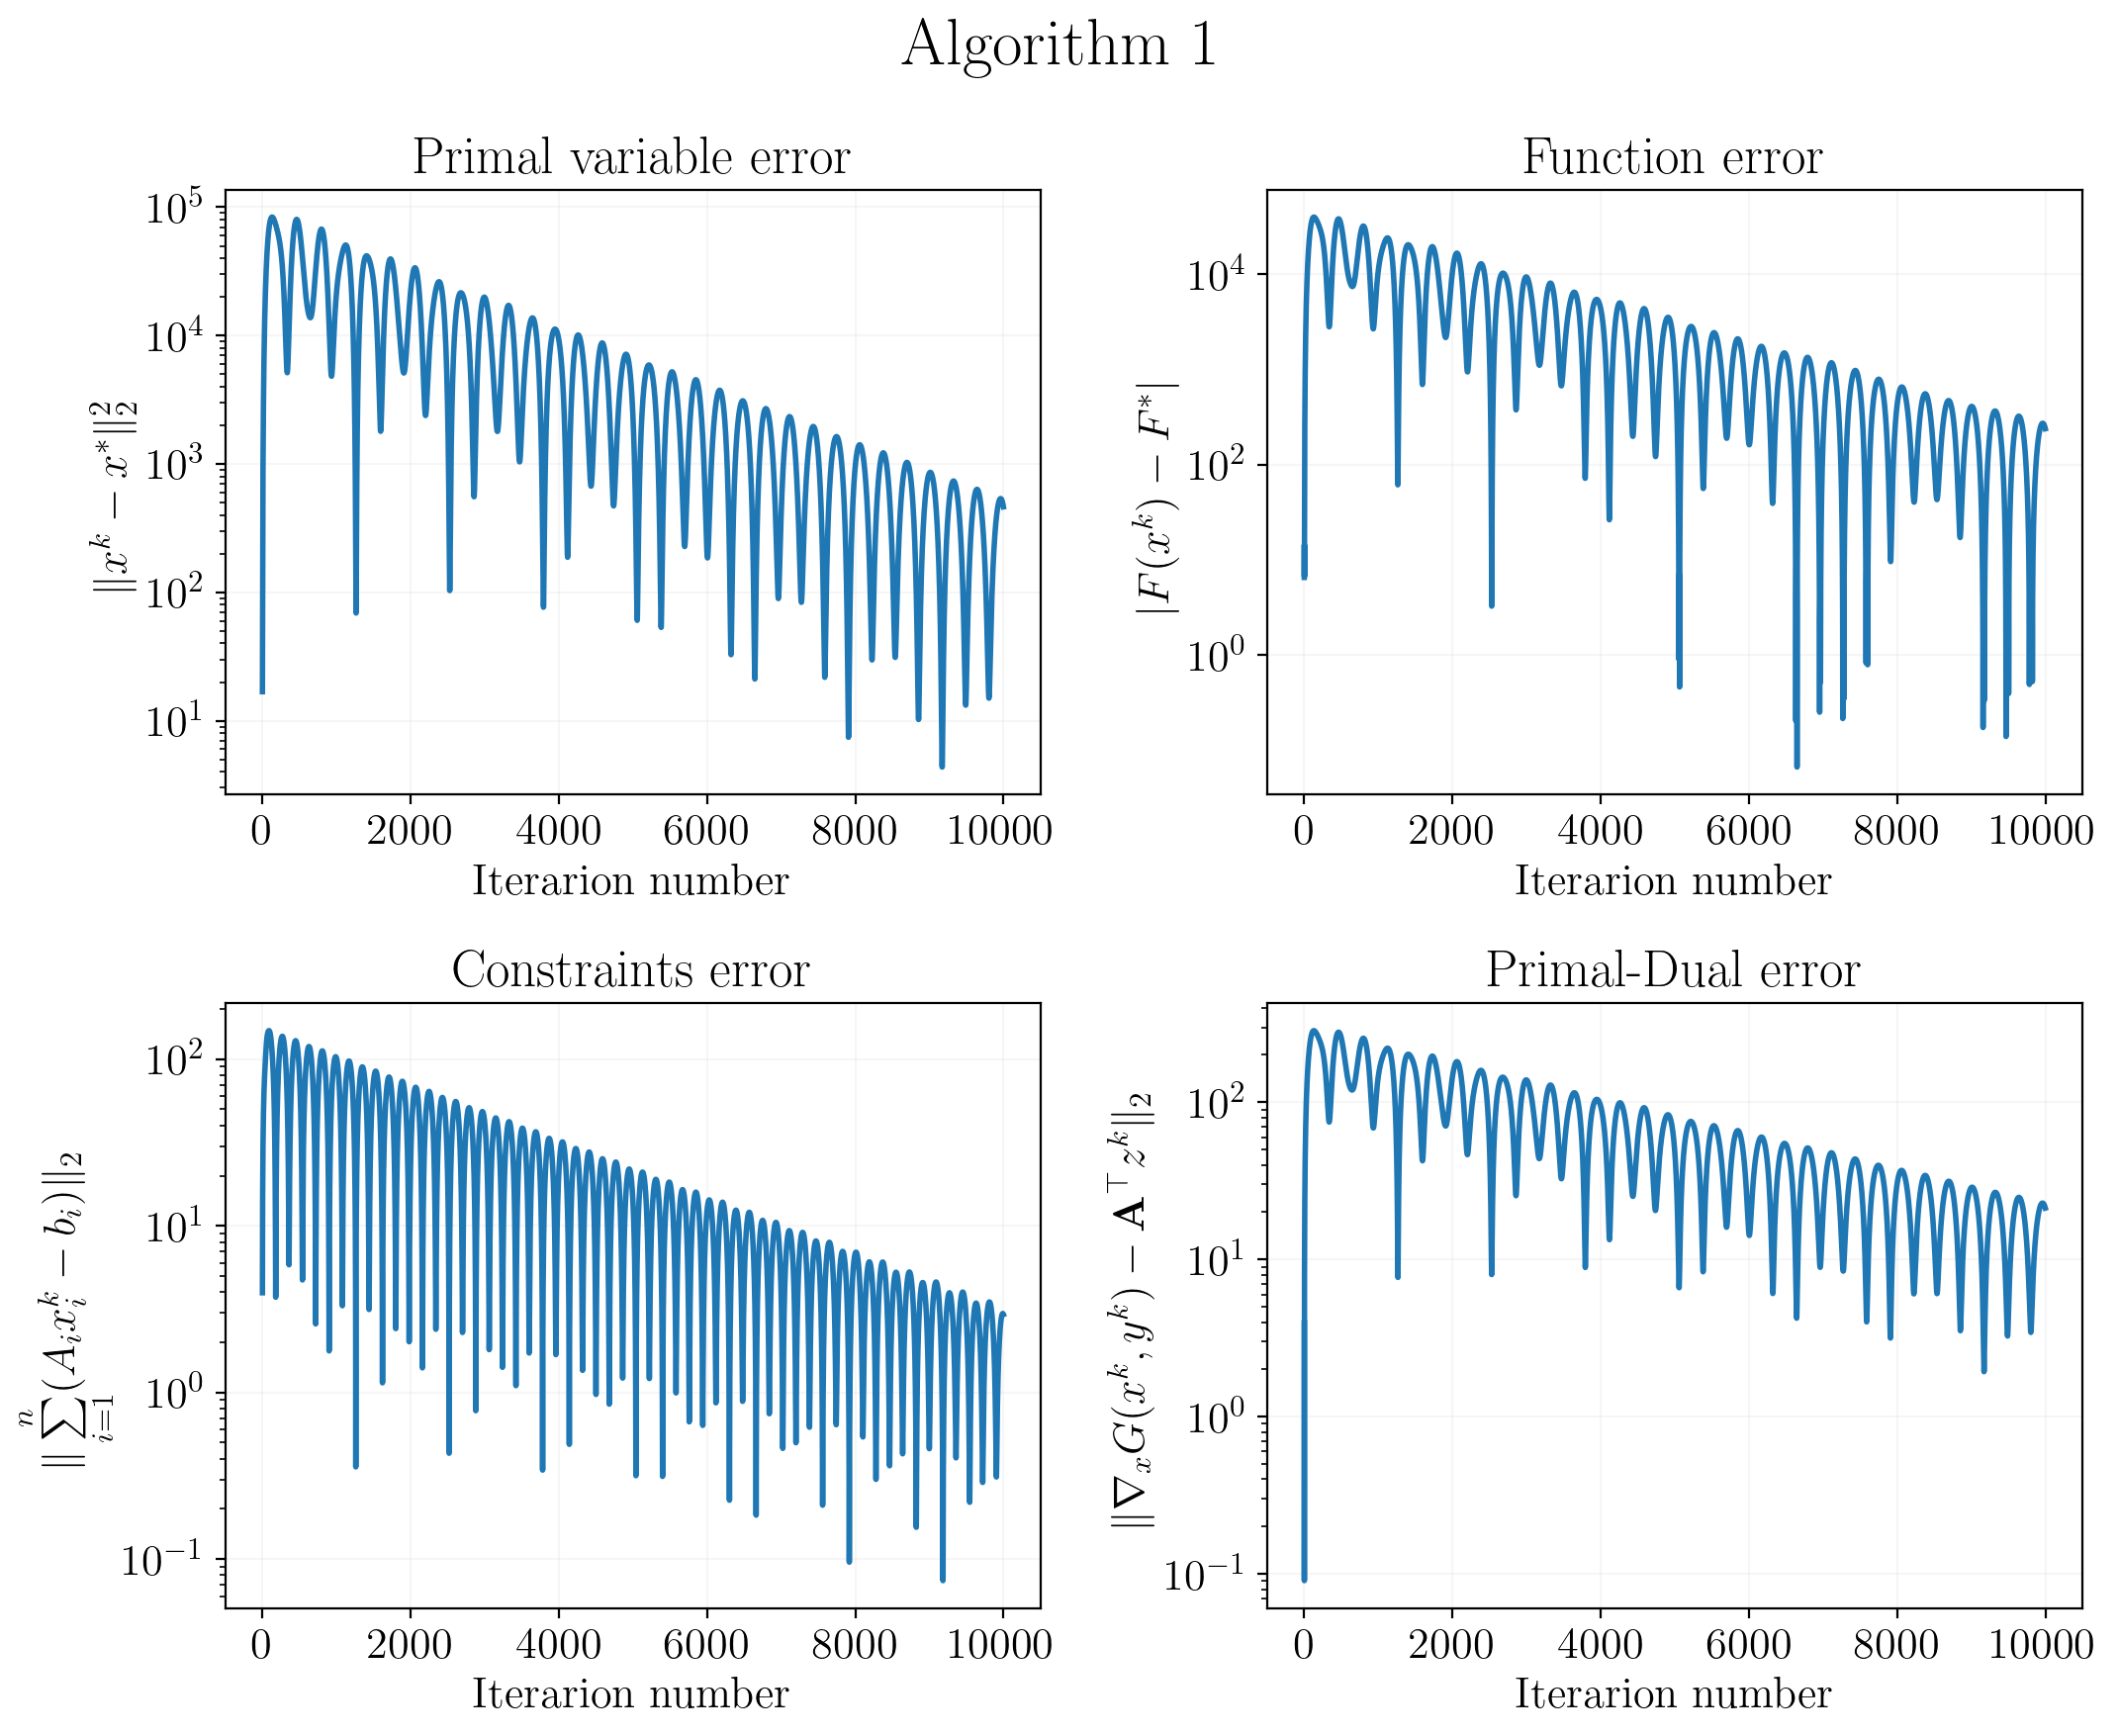

In [3]:
x, x_err, F_err, cons_err, primal_dual_err, ts = algorithm_1(num_steps=NUM_STEPS, model=model)
plot_logs_pd(x_err, F_err, cons_err, primal_dual_err, title='Algorithm 1')

### Intermediate

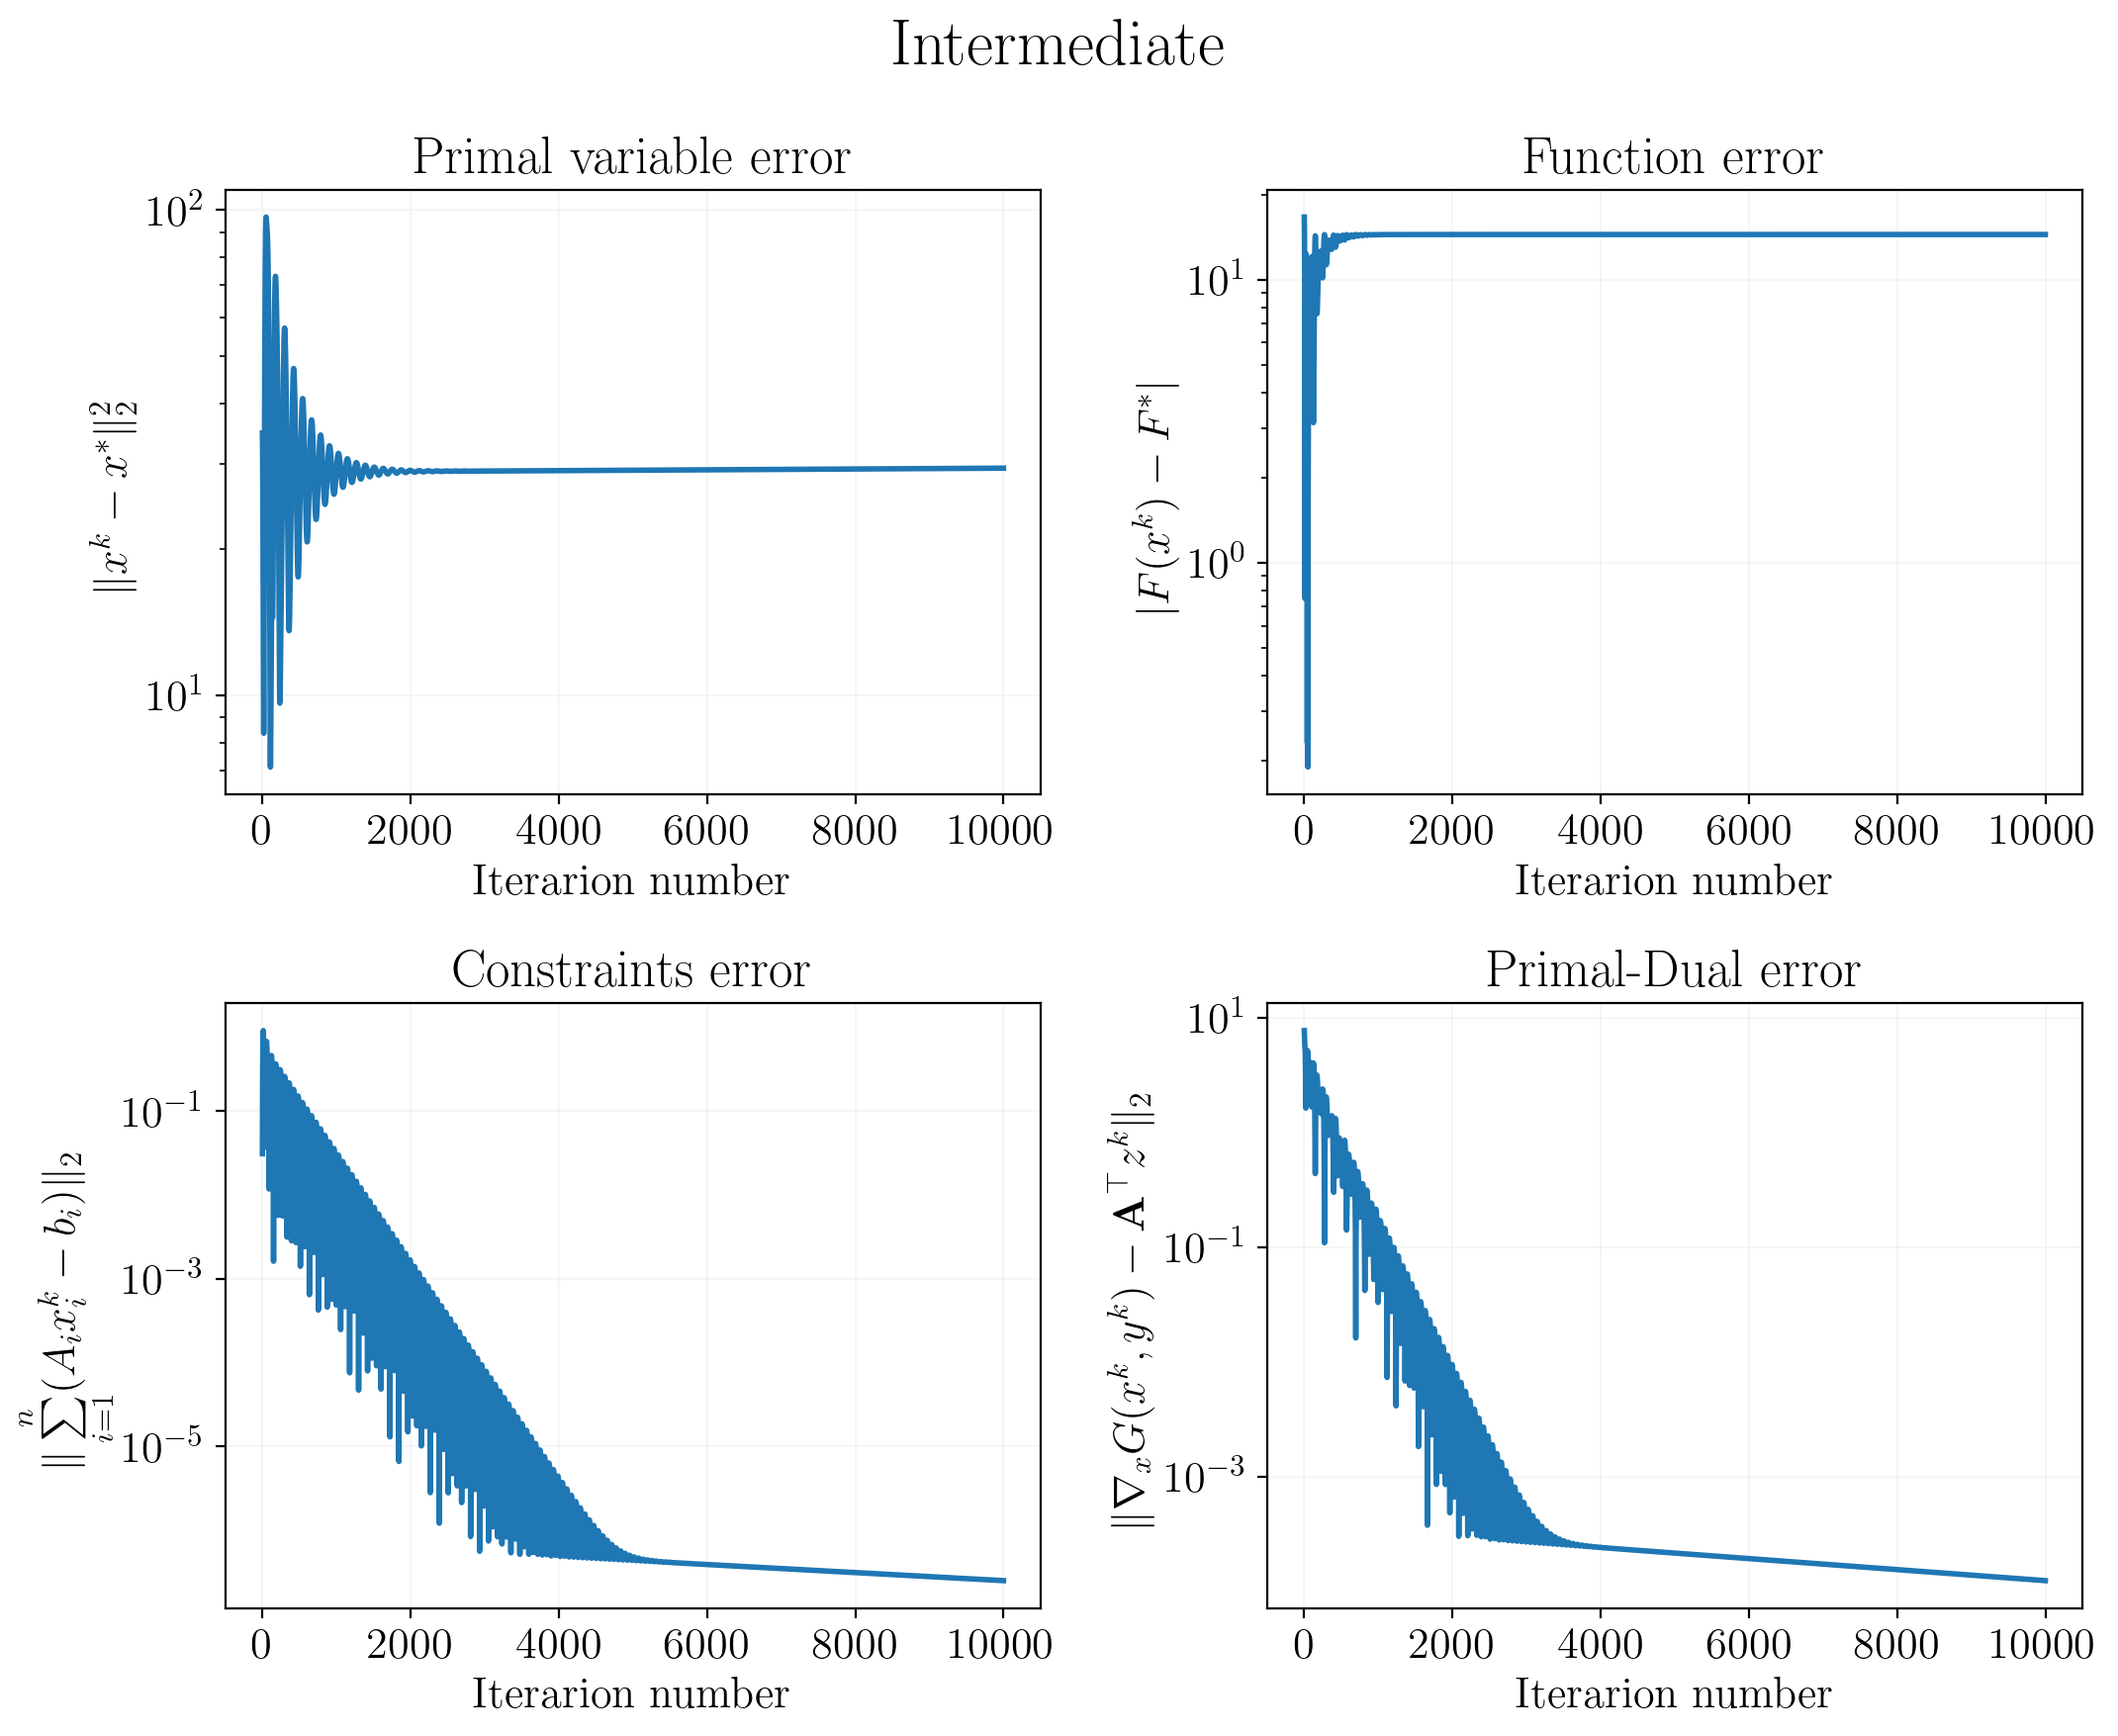

In [4]:
x, x_err, F_err, cons_err, primal_dual_err, ts = intermediate(num_steps=NUM_STEPS, model=model)
plot_logs_pd(x_err, F_err, cons_err, primal_dual_err, title='Intermediate')

### Salim

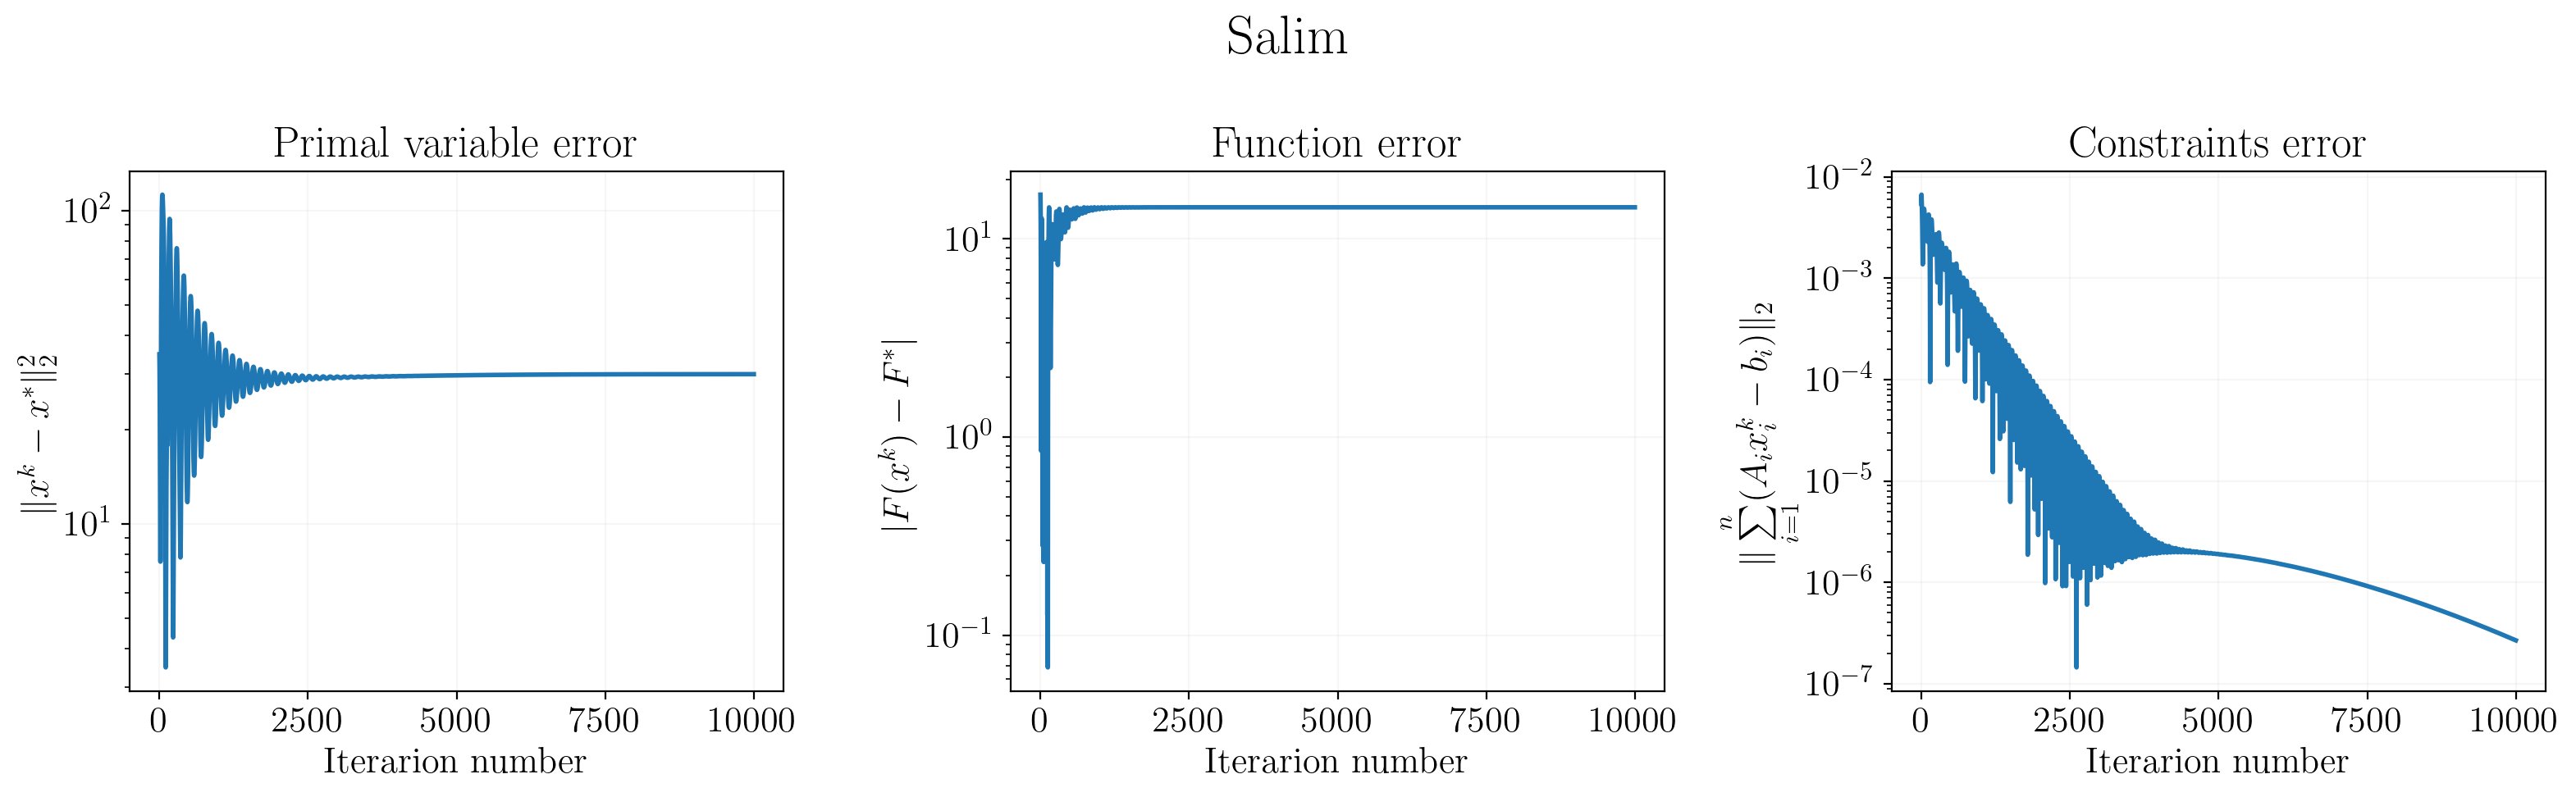

In [5]:
x, x_err, F_err, cons_err, ts = salim(num_steps=NUM_STEPS, model=model)
plot_logs(x_err, F_err, cons_err, title='Salim')

### Tracking-ADMM

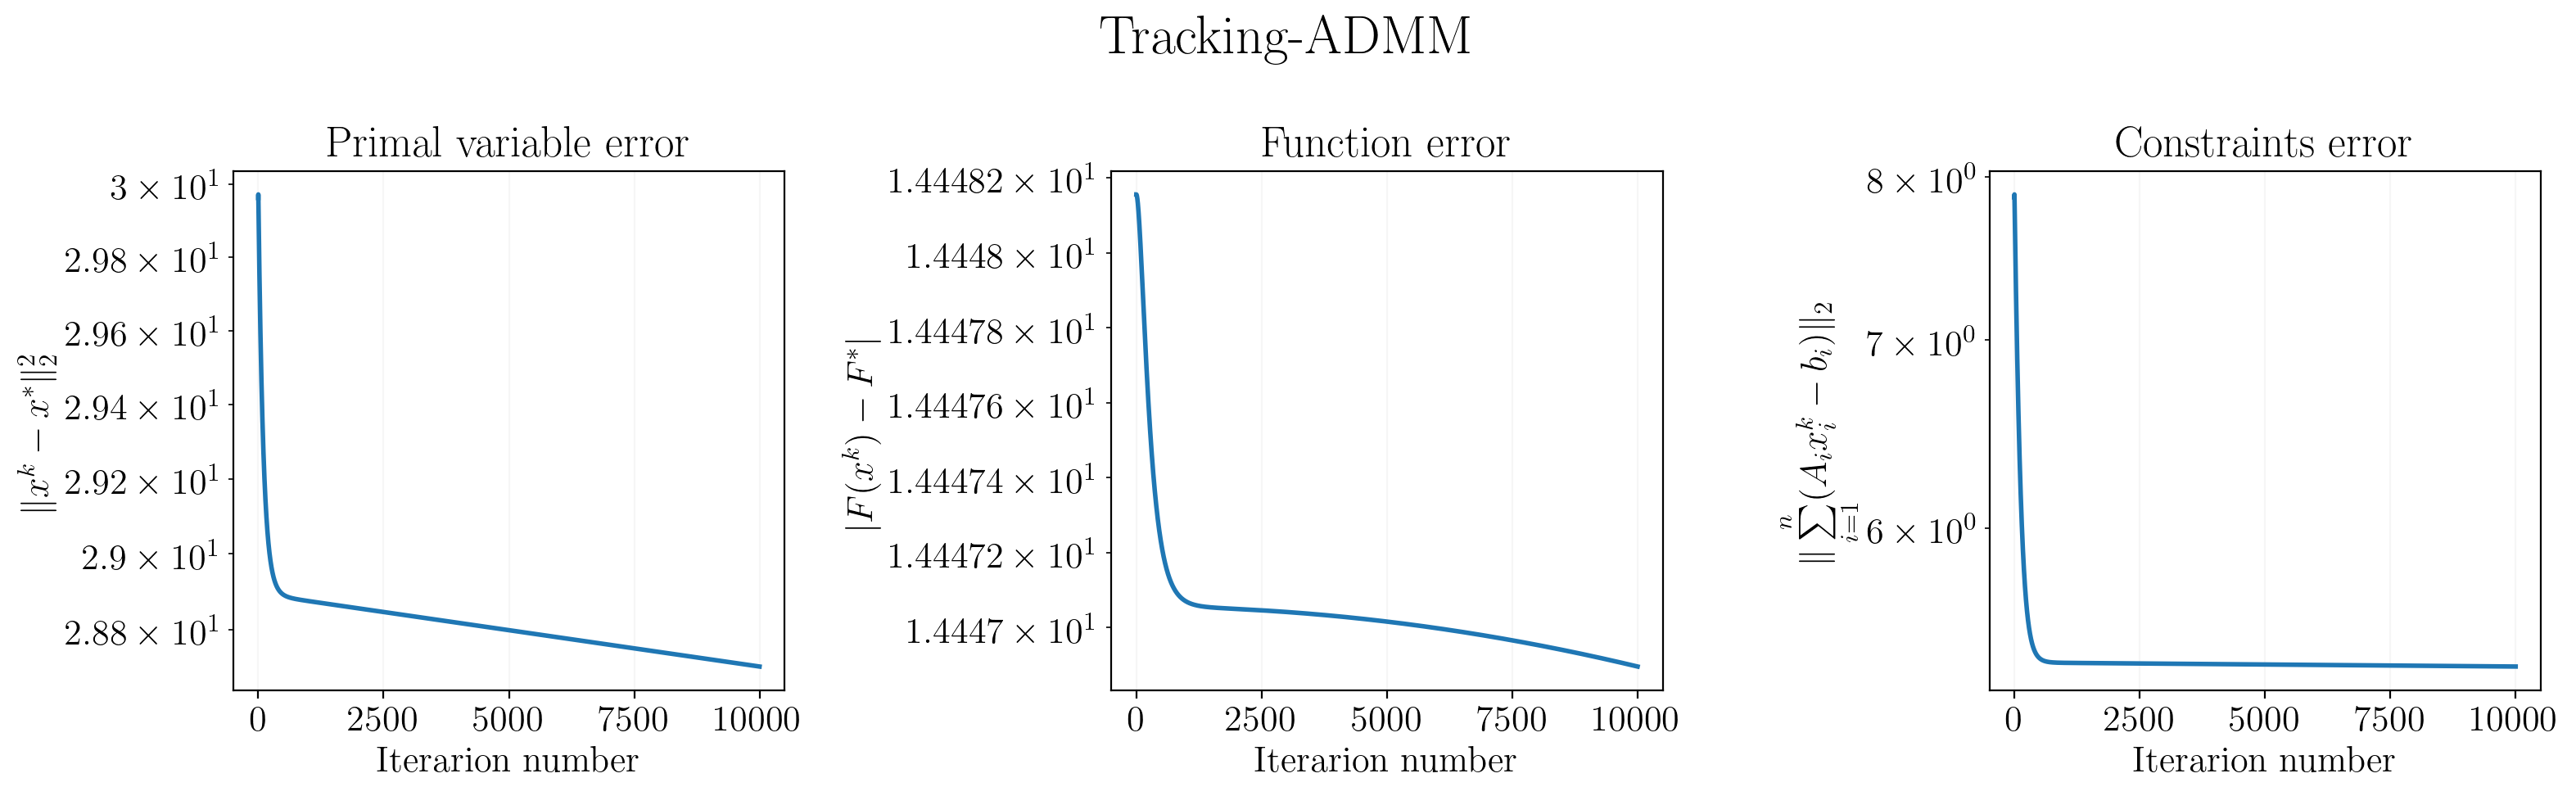

In [6]:
x, x_err, F_err, cons_err, ts = TrackingADMM(num_steps=NUM_STEPS, model=model)
plot_logs(x_err, F_err, cons_err, title='Tracking-ADMM')

### DPMM

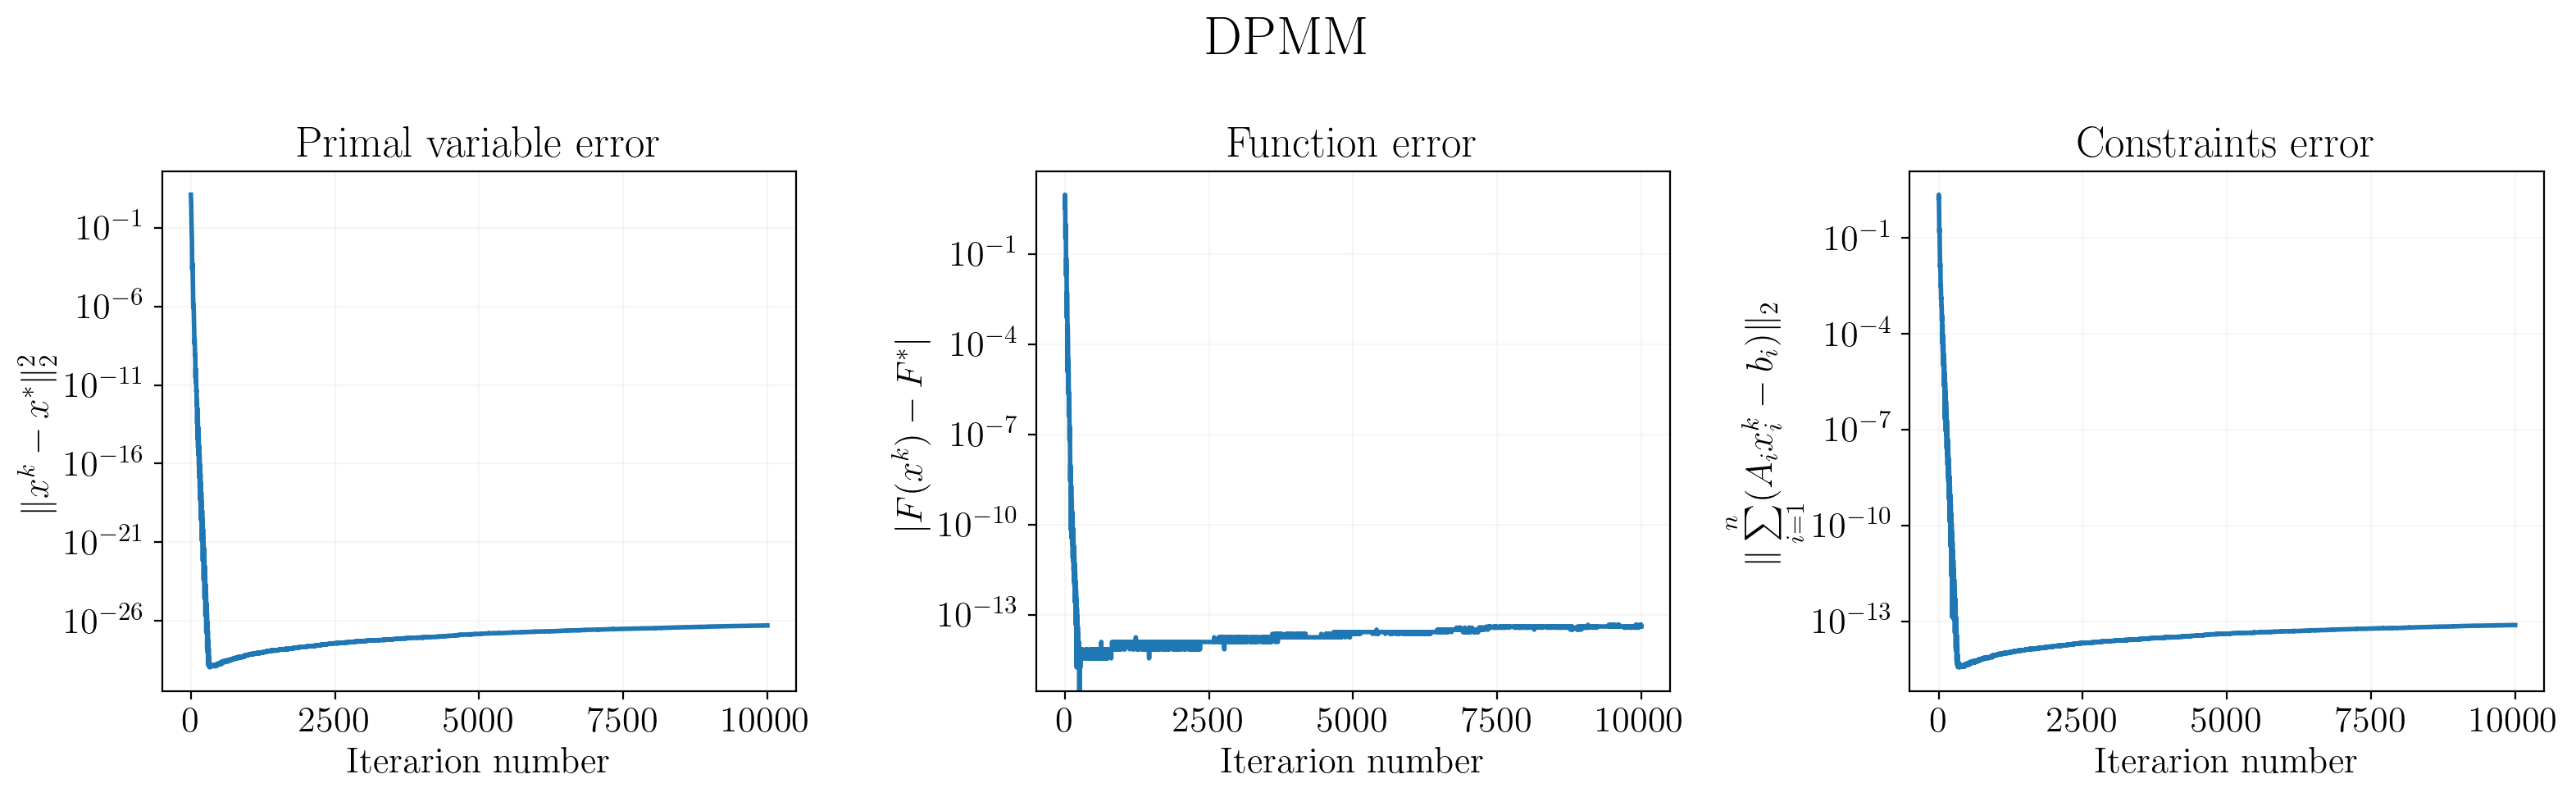

In [7]:
x, x_err, F_err, cons_err, ts = DPMM(num_steps=NUM_STEPS, model=model)
plot_logs(x_err, F_err, cons_err, title='DPMM')

### Comparison

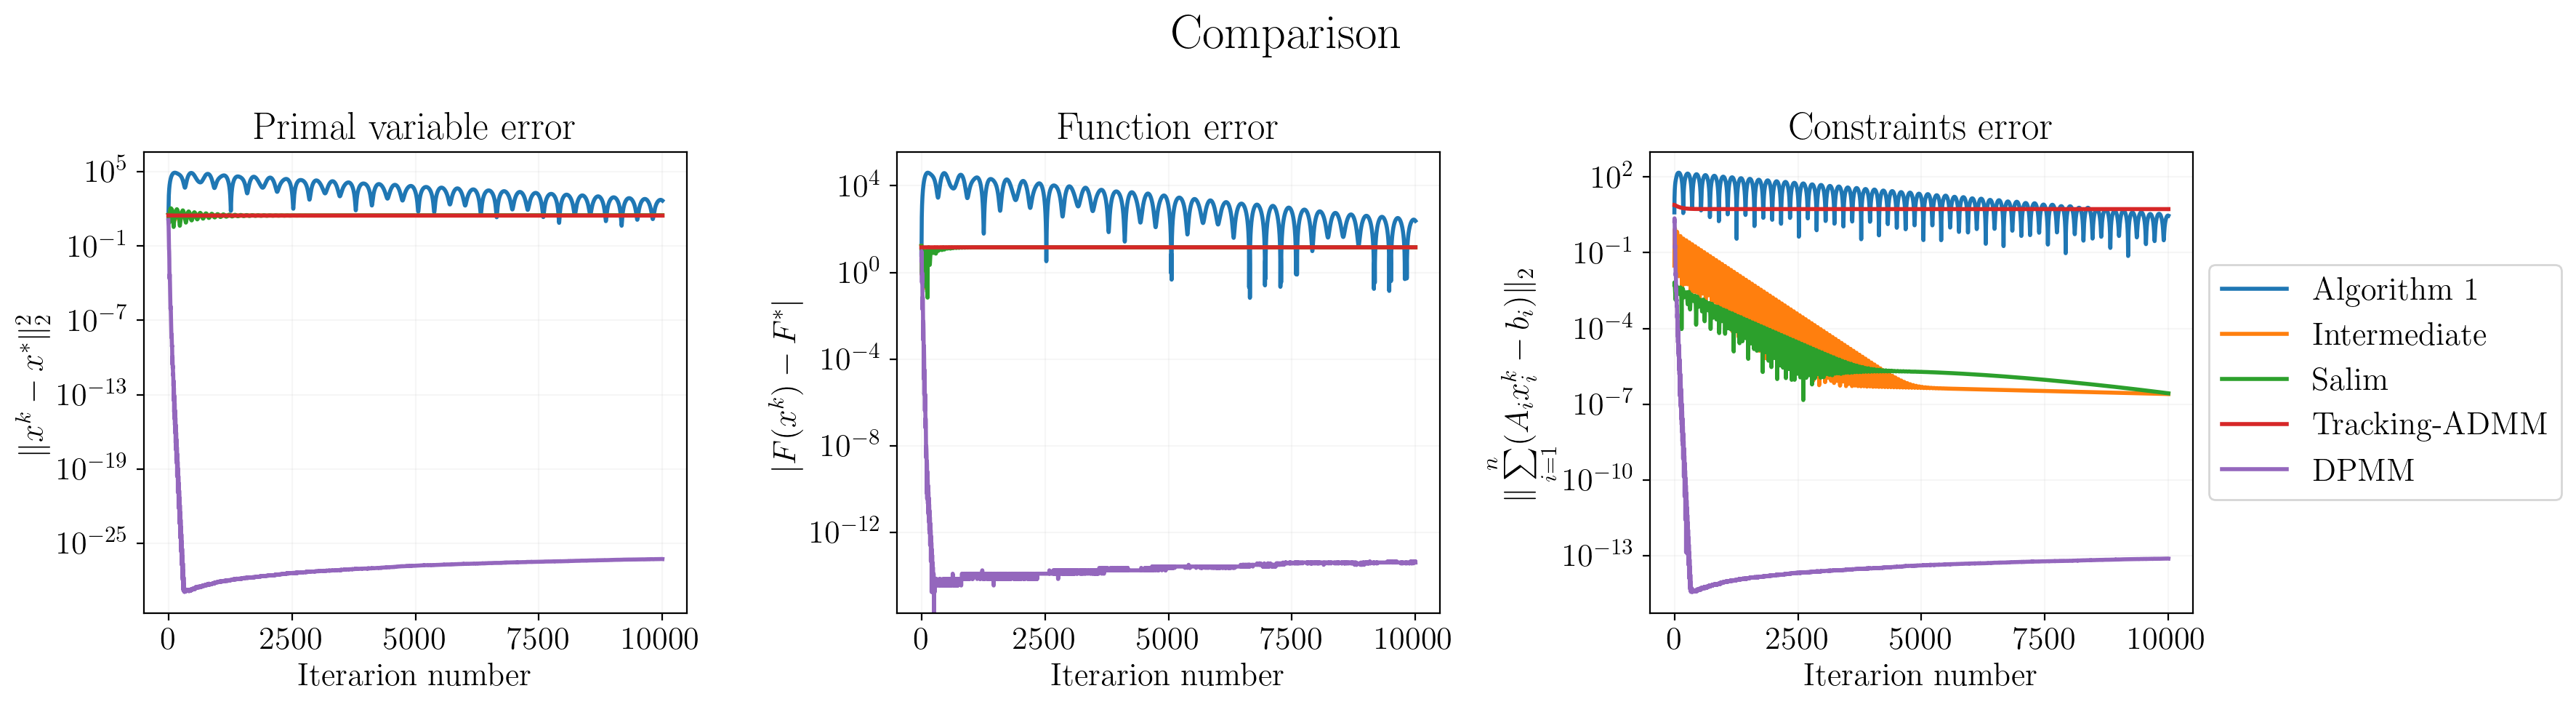

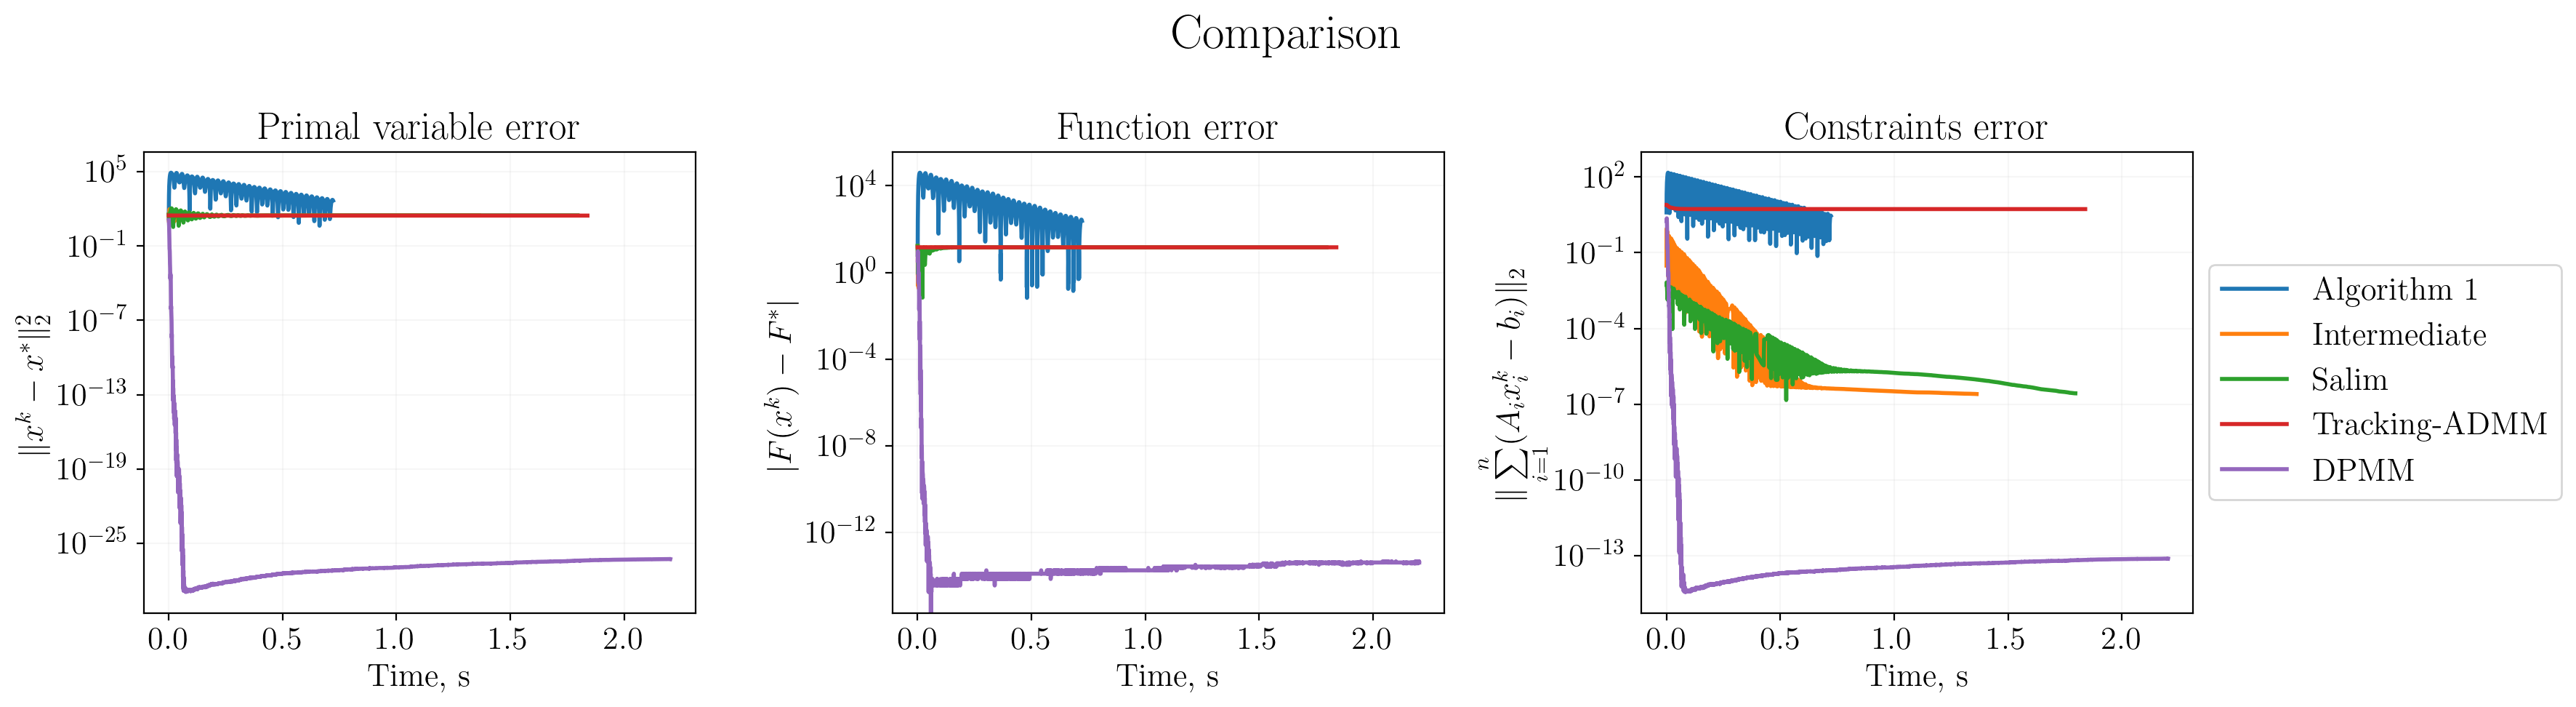

In [8]:
titles = ['Algorithm 1', 'Intermediate', 'Salim', 'Tracking-ADMM', 'DPMM']
methods = [algorithm_1, intermediate, salim, TrackingADMM, DPMM]
results = {title: {} for title in titles}

for (title, method) in zip(titles, methods):
    result = method(num_steps=NUM_STEPS, model=model)
    results[title]['x_err'] = result[1]
    results[title]['F_err'] = result[2]
    results[title]['cons_err'] = result[3]
    results[title]['ts'] = result[-1]

plot_comparison_iteration(results)
plot_comparison_time(results)

## Labels are distributed between devices

$$ x_1 = \begin{pmatrix} w_1 \\ z_1 \end{pmatrix}, \quad x_2 = \begin{pmatrix} w_2 \\ z_2 \end{pmatrix}, \quad \ldots, \quad x_n = \begin{pmatrix} w_n \\ z_n \end{pmatrix} $$

$$ f_i(x_i) = f_i(w_i, z_i) = \frac{1}{2}\|z_i - l_i\|_2^2 + \lambda \|w_i\|_2^2, \quad i = 1, \ldots, n $$

$$ A_i = \begin{pmatrix} \mathbf{F}_i & \mathbf{C}_i \end{pmatrix}, \qquad \mathbf{C}_i = \begin{pmatrix} \mathbf{O}_{\mathrm{dim}(z_i)} \\ \vdots \\ -\mathbf{I}_{\mathrm{dim}(z_i)} \\ \vdots \\ \mathbf{O}_{\mathrm{dim}(z_i)} \end{pmatrix}, \quad i = 1, \ldots, n $$

We can use `mushrooms` dataset.

In [ ]:
np.random.seed(307)

train_size = 0.05 # 8124 // 20 = 406
NUM_STEPS = 1000
NUM_NODES = 14 # 112 % 14 = 0
TITLE = 'mushrooms'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e-3, title=TITLE, train_size=train_size, graph=graph, edge_prob=0.5, gossip=False,
            labels_distribution=True)

Or `a9a` dataset.

In [ ]:
np.random.seed(307)

train_size = 0.02 # 32561 // 50 = 651
NUM_STEPS = 1000
NUM_NODES = 3 # 123 % 3 = 0
TITLE = 'a9a'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e-2, title=TITLE, train_size=train_size, graph=graph, edge_prob=0.5, gossip=False,
            labels_distribution=True)

And `w8a` dataset.

In [ ]:
np.random.seed(307)

train_size = 0.01 # 49749 // 100 = 497
NUM_STEPS = 1000
NUM_NODES = 10 # 300 % 10 = 30
TITLE = 'w8a'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e-3, title=TITLE, train_size=train_size, graph=graph, edge_prob=0.5, gossip=True,
            labels_distribution=True)

Also we can use synthetic linear regression dataset.

In [9]:
np.random.seed(307)

NUM_STEPS = 10000
NUM_NODES = 3
TITLE = 'synthetic'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, lmbd=1e-3, title=TITLE, graph=graph, edge_prob=0.5, gossip=False, labels_distribution=True)

### Algorithm 1

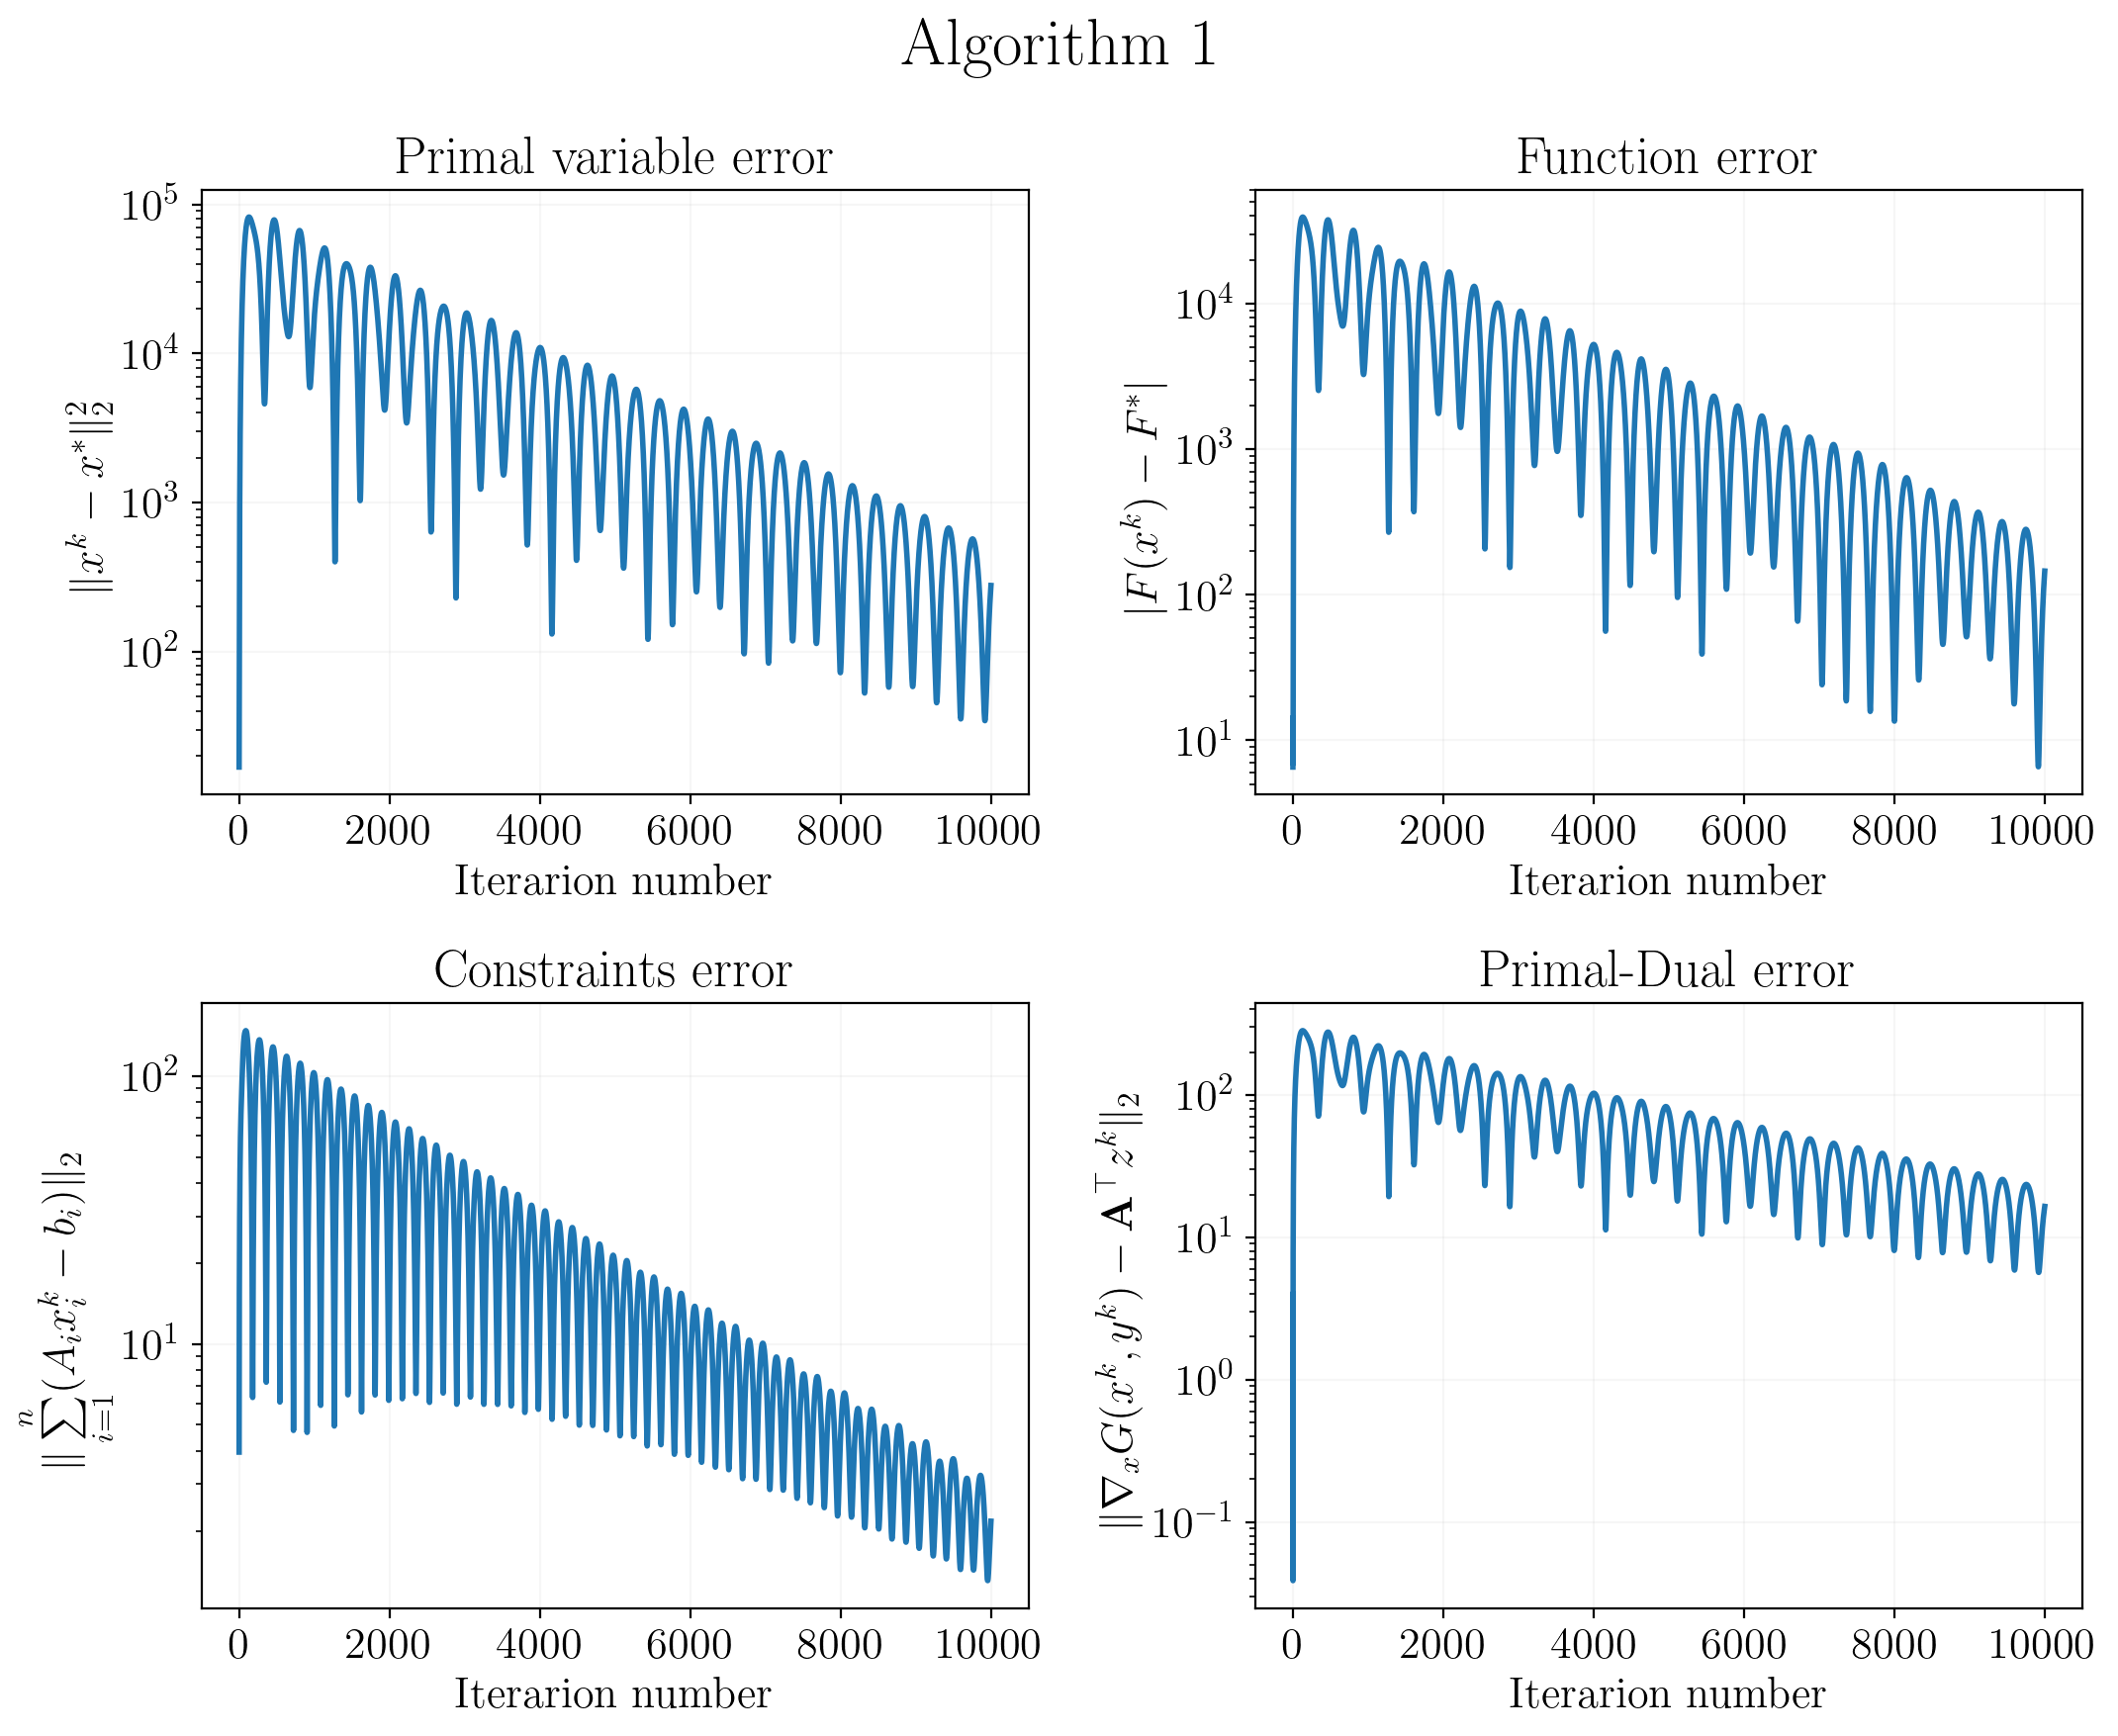

In [10]:
x, x_err, F_err, cons_err, primal_dual_err, ts = algorithm_1(num_steps=NUM_STEPS, model=model)
plot_logs_pd(x_err, F_err, cons_err, primal_dual_err, title='Algorithm 1')

### Intermediate

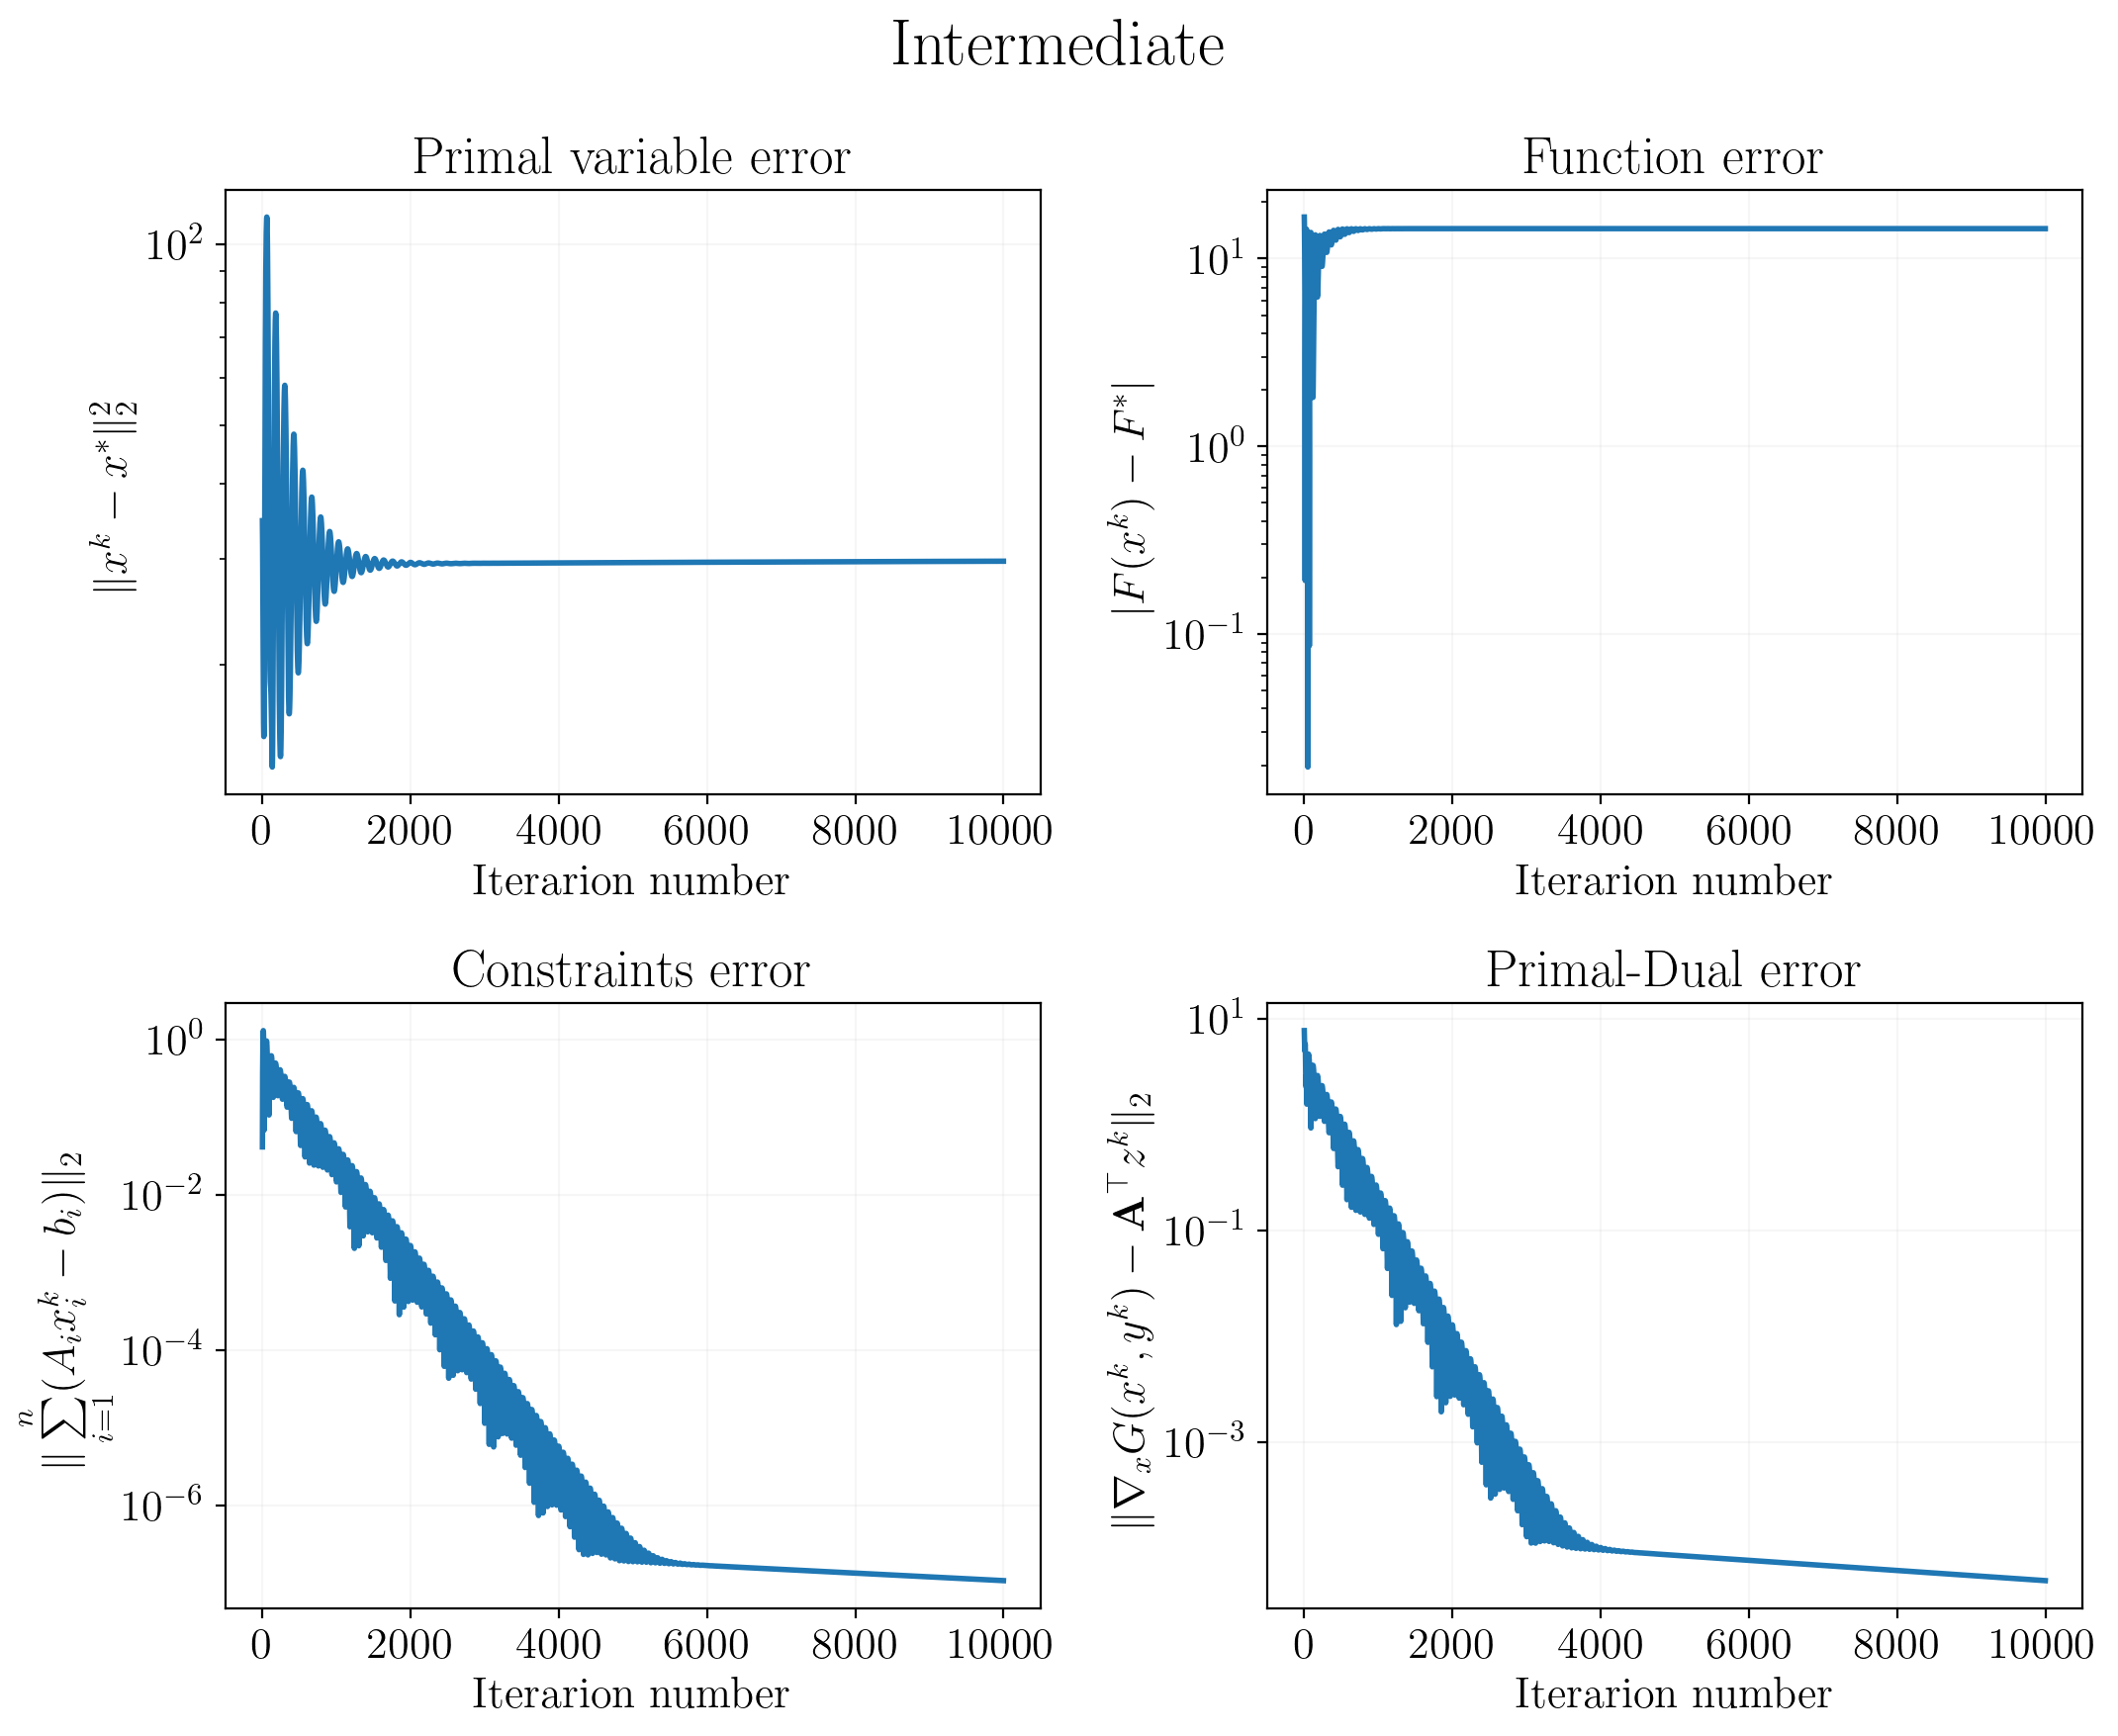

In [11]:
x, x_err, F_err, cons_err, primal_dual_err, ts = intermediate(num_steps=NUM_STEPS, model=model)
plot_logs_pd(x_err, F_err, cons_err, primal_dual_err, title='Intermediate')

### Salim

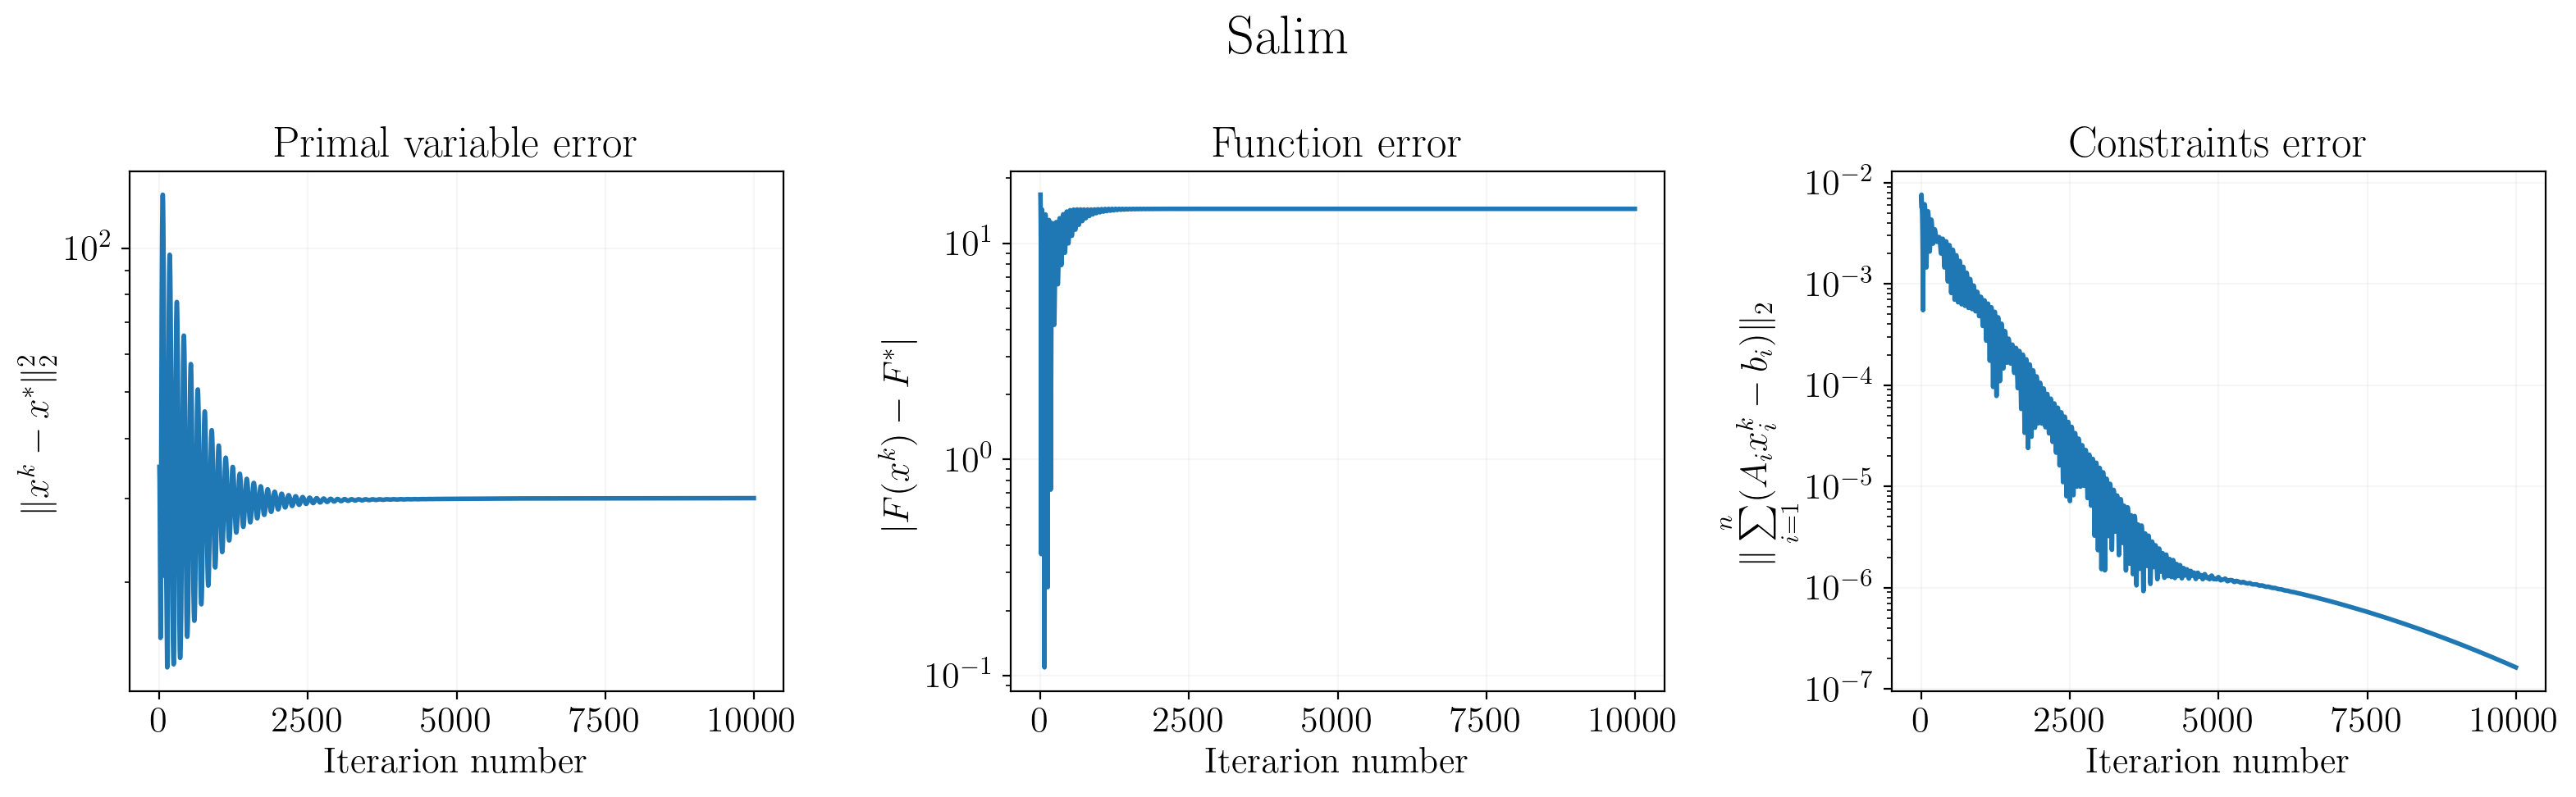

In [12]:
x, x_err, F_err, cons_err, ts = salim(num_steps=NUM_STEPS, model=model)
plot_logs(x_err, F_err, cons_err, title='Salim')

### Tracking-ADMM

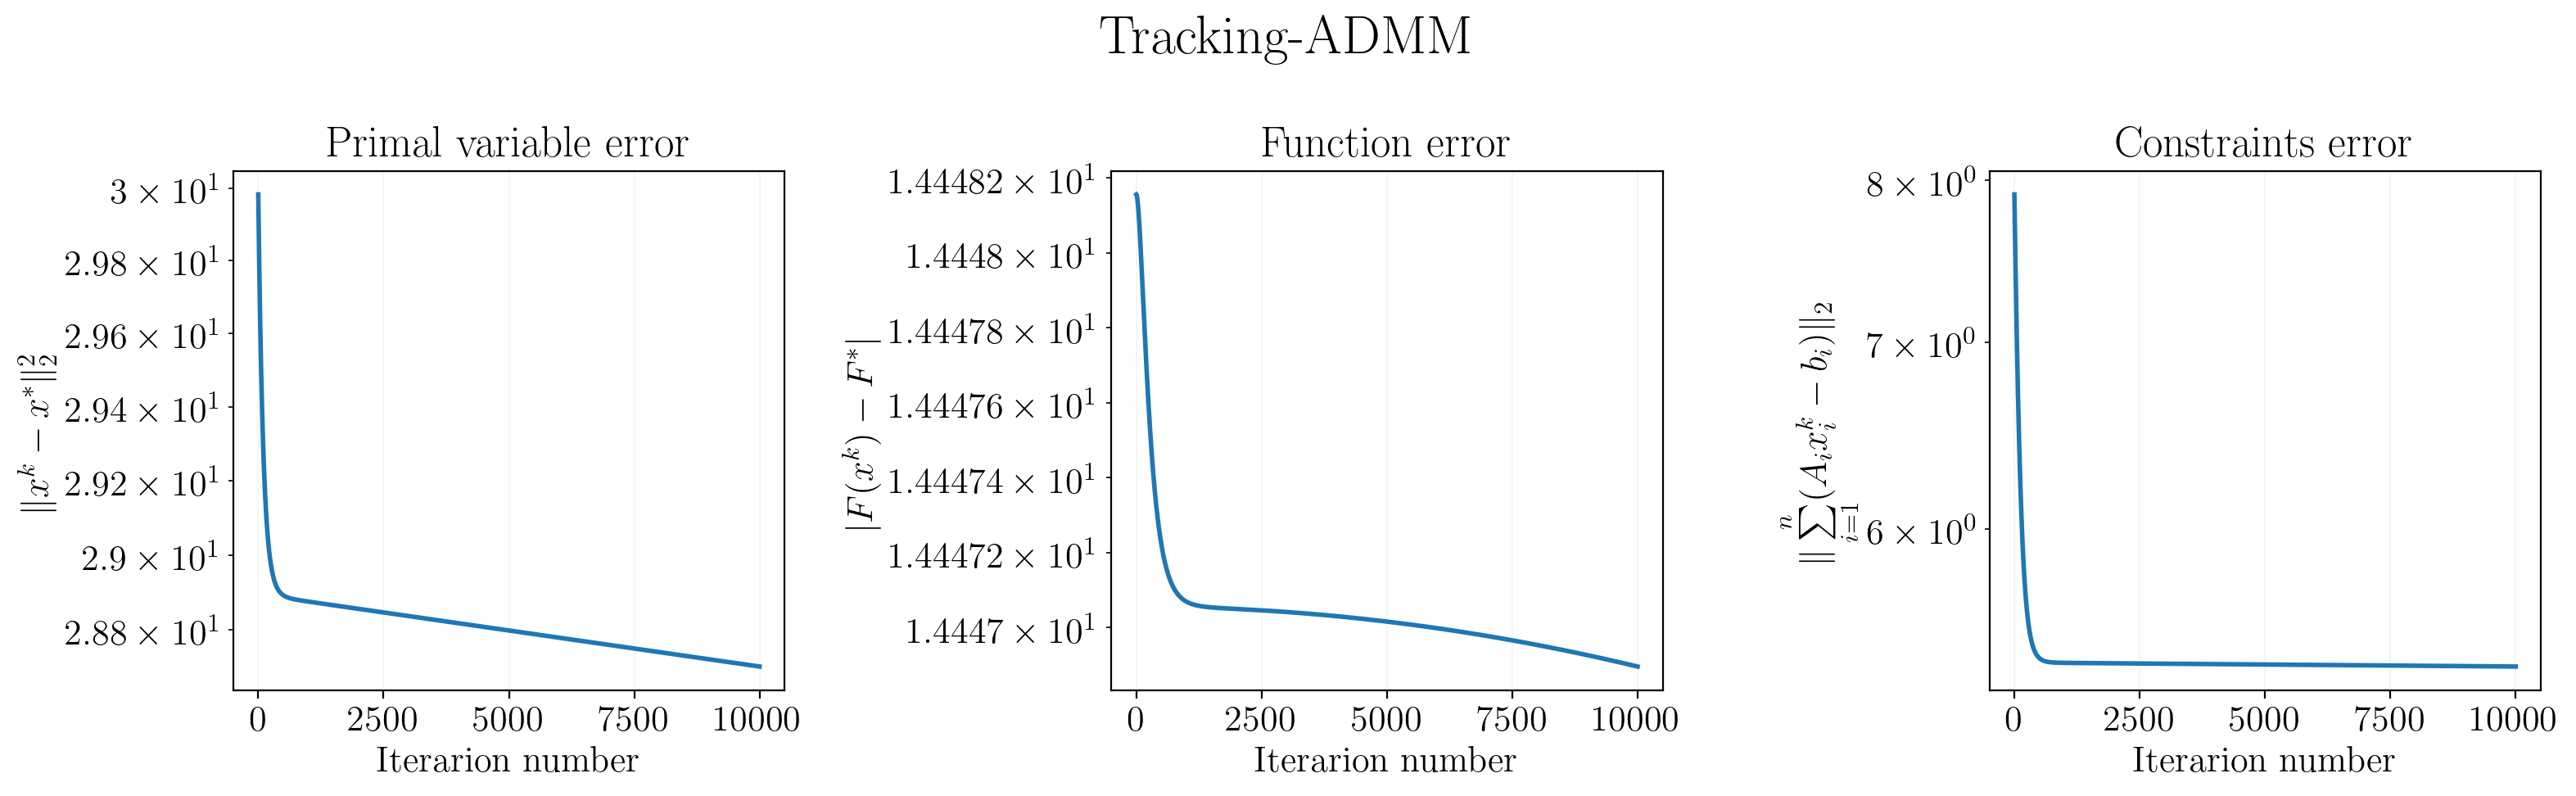

In [13]:
x, x_err, F_err, cons_err, ts = TrackingADMM(num_steps=NUM_STEPS, model=model)
plot_logs(x_err, F_err, cons_err, title='Tracking-ADMM')

### DPMM

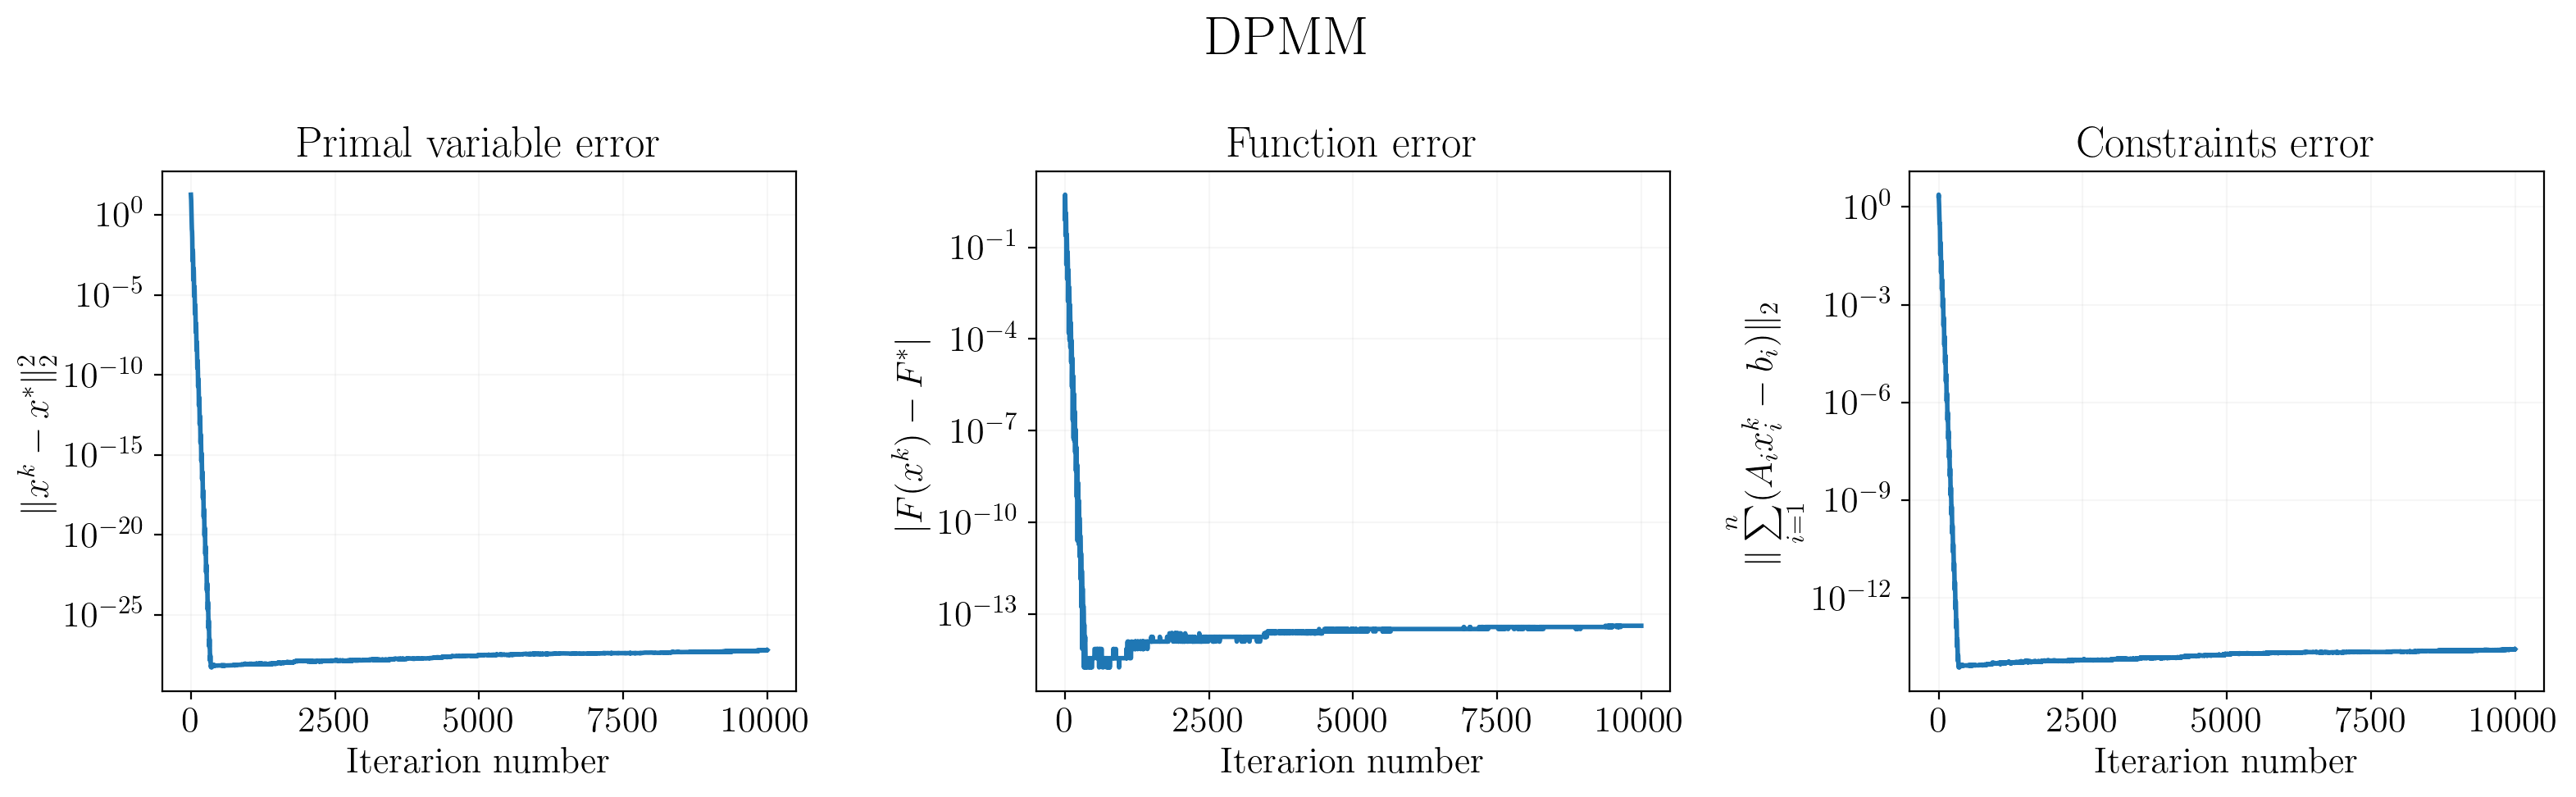

In [14]:
x, x_err, F_err, cons_err, ts = DPMM(num_steps=NUM_STEPS, model=model)
plot_logs(x_err, F_err, cons_err, title='DPMM')

### Comparison

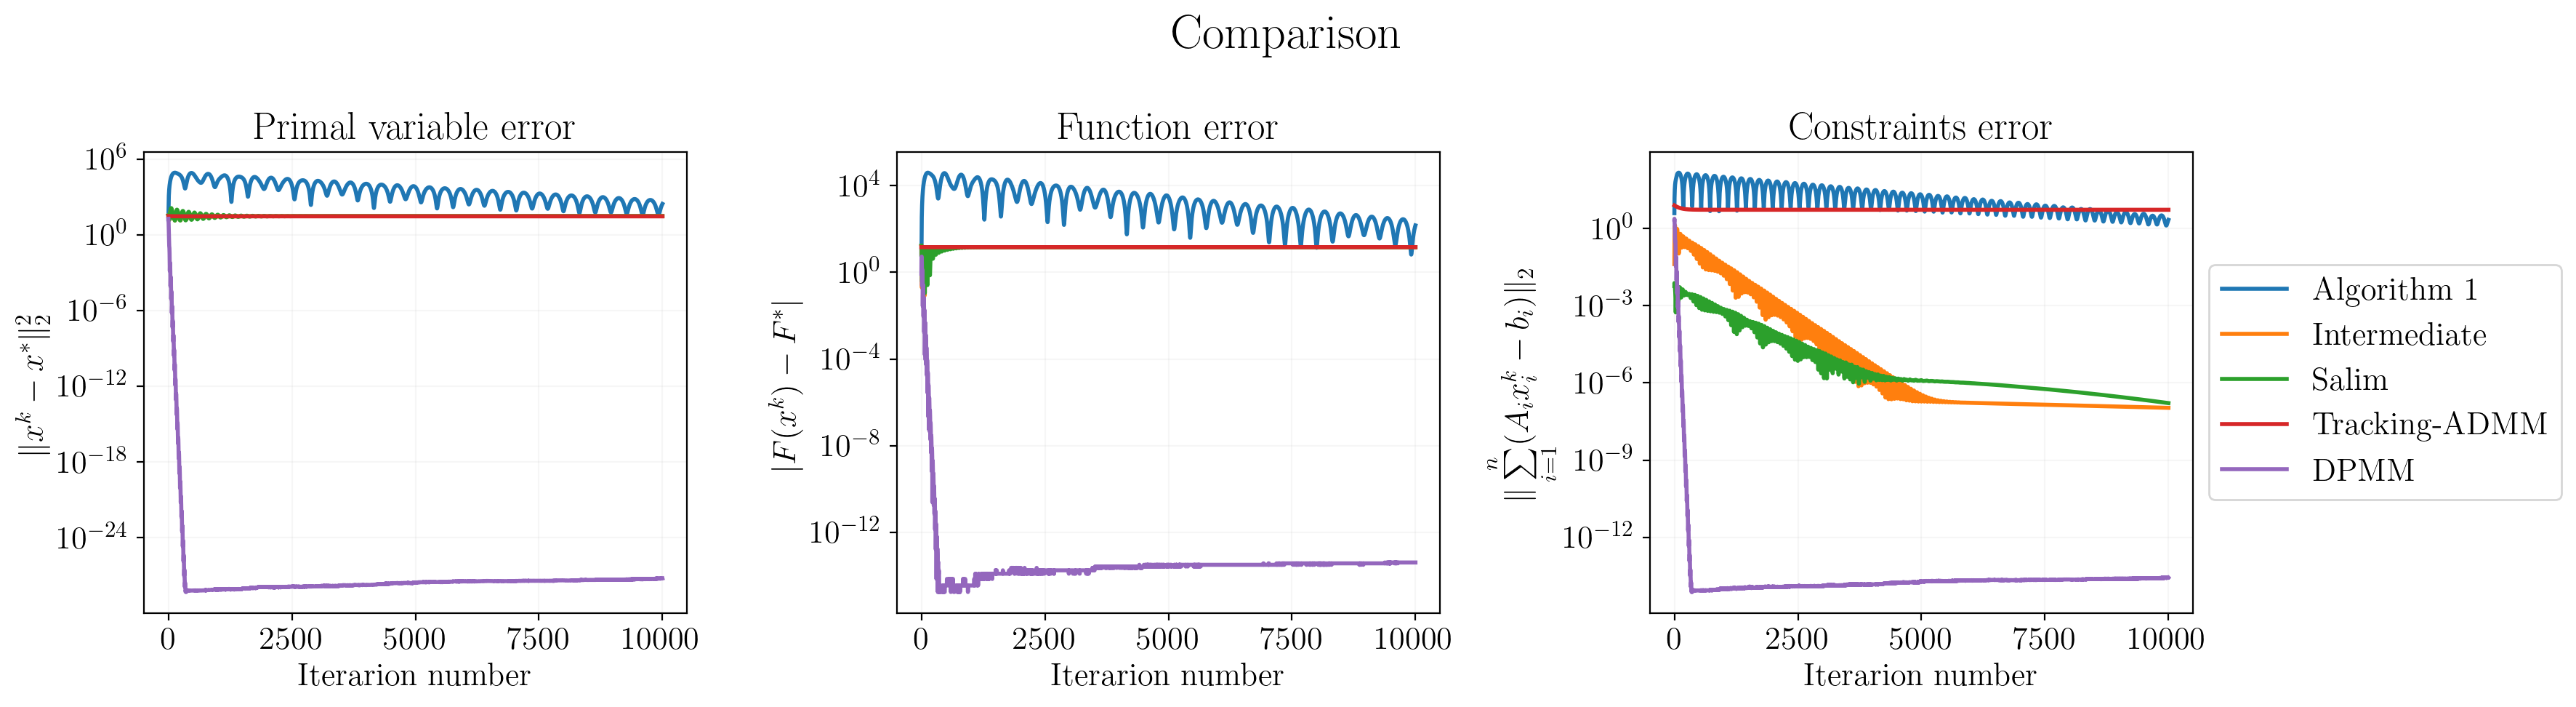

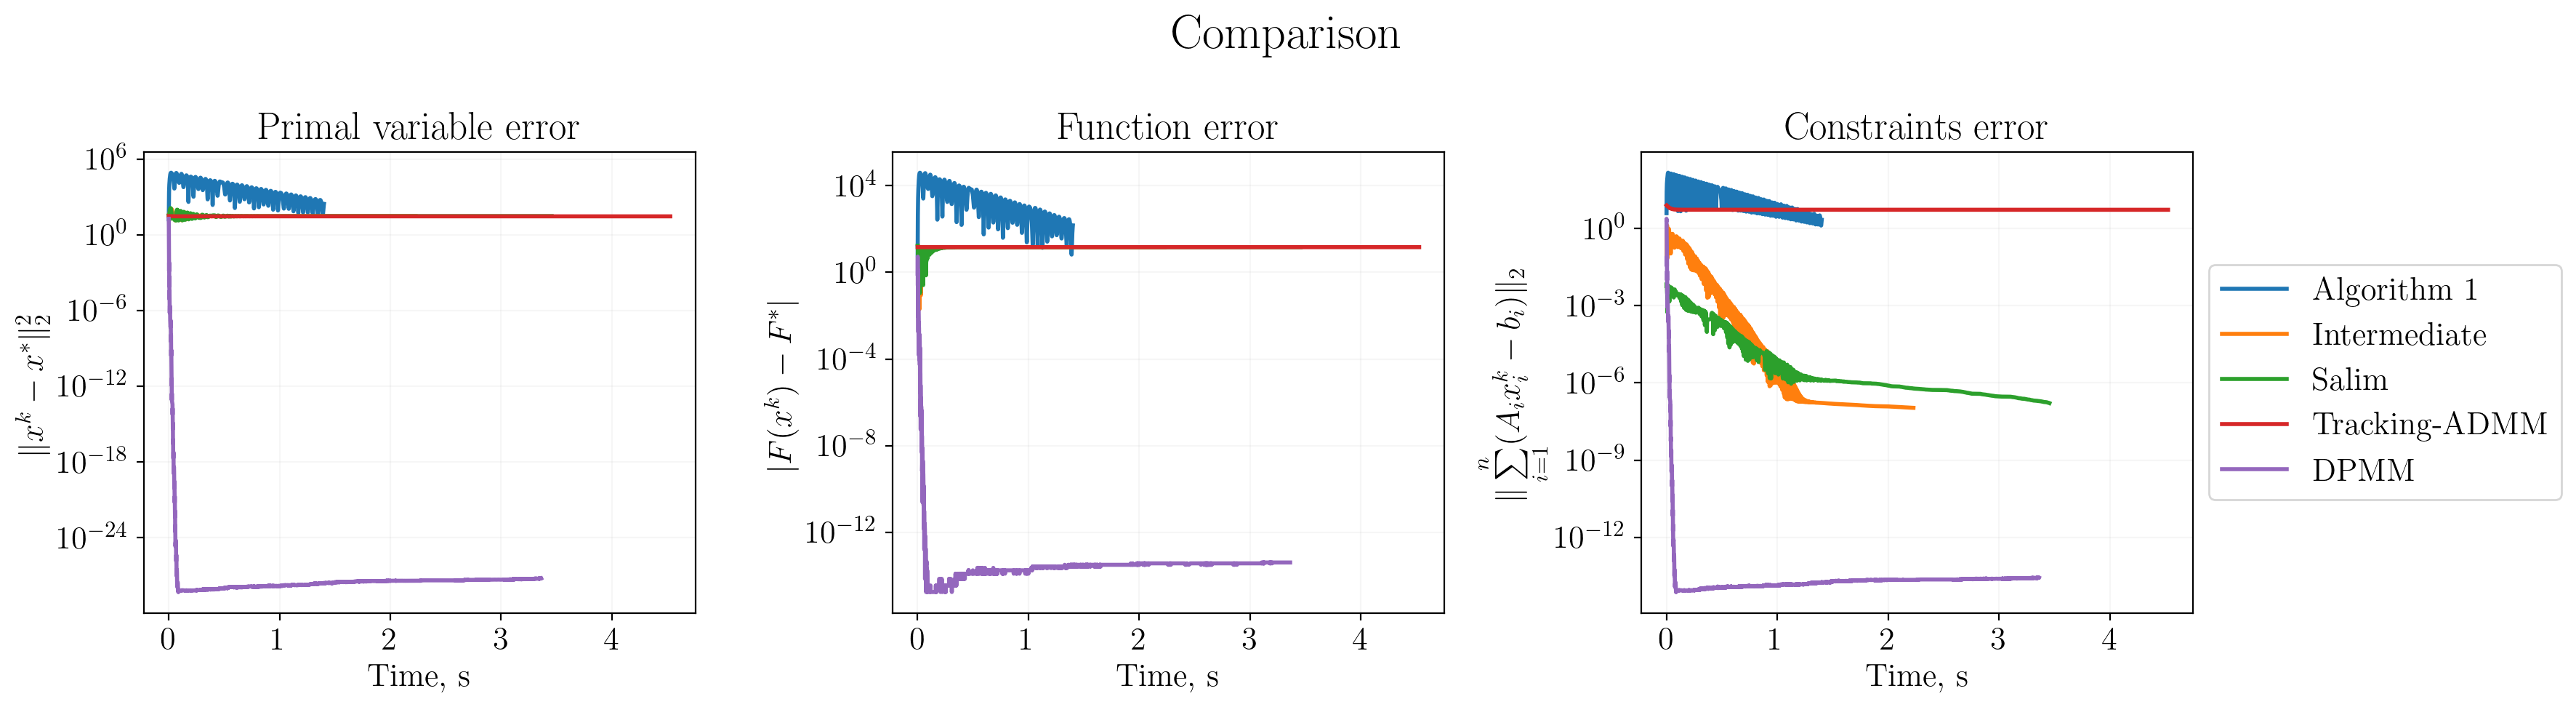

In [15]:
titles = ['Algorithm 1', 'Intermediate', 'Salim', 'Tracking-ADMM', 'DPMM']
methods = [algorithm_1, intermediate, salim, TrackingADMM, DPMM]
results = {title: {} for title in titles}

for (title, method) in zip(titles, methods):
    result = method(num_steps=NUM_STEPS, model=model)
    results[title]['x_err'] = result[1]
    results[title]['F_err'] = result[2]
    results[title]['cons_err'] = result[3]
    results[title]['ts'] = result[-1]

plot_comparison_iteration(results)
plot_comparison_time(results)